In [1]:
import keras
from keras.models import Sequential
from keras.applications.resnet_v2 import ResNet101V2
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train_2.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
24136,winKen_wave_u_cm_np1_ri_bad_1_frame0.jpg,wave
24137,winKen_wave_u_cm_np1_ri_bad_1_frame1.jpg,wave
24138,winKen_wave_u_cm_np1_ri_bad_1_frame2.jpg,wave
24139,winKen_wave_u_cm_np1_ri_bad_1_frame3.jpg,wave
24140,winKen_wave_u_cm_np1_ri_bad_1_frame4.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 24141/24141 [04:11<00:00, 95.90it/s] 


In [4]:
# converting the list to numpy array
X = np.array(train_image,np.float16)
train_image=[]
# shape of the array
X.shape

(24141, 224, 224, 3)

In [5]:
# separating the target
y = train['class']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [6]:
X=[]
y=[]

In [7]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19312, 224, 224, 3)
(4829, 224, 224, 3)
(19312, 51)
(4829, 51)


In [9]:
# creating the base model of pre-trained ResNet101V2 model
base_model = ResNet101V2(weights='imagenet', include_top=False)

In [10]:
print(base_model.output_shape)

(None, None, None, 2048)


In [11]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

__________________________________________________________________________________________________
conv2_block3_out (Add)          (None, None, None, 2 0           max_pooling2d_1[0][0]            
                                                                 conv2_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_preact_bn (BatchNo (None, None, None, 2 1024        conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_preact_relu (Activ (None, None, None, 2 0           conv3_block1_preact_bn[0][0]     
__________________________________________________________________________________________________
conv3_block1_1_conv (Conv2D)    (None, None, None, 1 32768       conv3_block1_preact_relu[0][0]   
__________________________________________________________________________________________________
conv3_bloc

__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, None, None, 1 0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_pad (ZeroPadding (None, None, None, 1 0           conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, None, None, 1 147456      conv3_block4_2_pad[0][0]         
__________________________________________________________________________________________________
conv3_block4_2_bn (BatchNormali (None, None, None, 1 512         conv3_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_relu (Activation (None, None, None, 1 0           conv3_block4_2_bn[0][0]          
__________

conv4_block3_2_relu (Activation (None, None, None, 2 0           conv4_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_3_conv (Conv2D)    (None, None, None, 1 263168      conv4_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block3_out (Add)          (None, None, None, 1 0           conv4_block2_out[0][0]           
                                                                 conv4_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_preact_bn (BatchNo (None, None, None, 1 4096        conv4_block3_out[0][0]           
__________________________________________________________________________________________________
conv4_block4_preact_relu (Activ (None, None, None, 1 0           conv4_block4_preact_bn[0][0]     
__________

conv4_block7_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block7_1_relu (Activation (None, None, None, 2 0           conv4_block7_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block7_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block7_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block7_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block7_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_block7_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block10_out (Add)         (None, None, None, 1 0           conv4_block9_out[0][0]           
                                                                 conv4_block10_3_conv[0][0]       
__________________________________________________________________________________________________
conv4_block11_preact_bn (BatchN (None, None, None, 1 4096        conv4_block10_out[0][0]          
__________________________________________________________________________________________________
conv4_block11_preact_relu (Acti (None, None, None, 1 0           conv4_block11_preact_bn[0][0]    
__________________________________________________________________________________________________
conv4_block11_1_conv (Conv2D)   (None, None, None, 2 262144      conv4_block11_preact_relu[0][0]  
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block14_2_pad (ZeroPaddin (None, None, None, 2 0           conv4_block14_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block14_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block14_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block14_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_relu (Activatio (None, None, None, 2 0           conv4_block14_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block14_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block14_2_relu[0][0]       
__________

__________________________________________________________________________________________________
conv4_block18_preact_bn (BatchN (None, None, None, 1 4096        conv4_block17_out[0][0]          
__________________________________________________________________________________________________
conv4_block18_preact_relu (Acti (None, None, None, 1 0           conv4_block18_preact_bn[0][0]    
__________________________________________________________________________________________________
conv4_block18_1_conv (Conv2D)   (None, None, None, 2 262144      conv4_block18_preact_relu[0][0]  
__________________________________________________________________________________________________
conv4_block18_1_bn (BatchNormal (None, None, None, 2 1024        conv4_block18_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block18_1_relu (Activatio (None, None, None, 2 0           conv4_block18_1_bn[0][0]         
__________

conv4_block21_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block21_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block21_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block21_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block21_2_relu (Activatio (None, None, None, 2 0           conv4_block21_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block21_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block21_2_relu[0][0]       
__________________________________________________________________________________________________
conv4_block21_out (Add)         (None, None, None, 1 0           conv4_block20_out[0][0]          
                                                                 conv4_block21_3_conv[0][0]       
__________

                                                                 conv5_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_preact_bn (BatchNo (None, None, None, 2 8192        conv5_block1_out[0][0]           
__________________________________________________________________________________________________
conv5_block2_preact_relu (Activ (None, None, None, 2 0           conv5_block2_preact_bn[0][0]     
__________________________________________________________________________________________________
conv5_block2_1_conv (Conv2D)    (None, None, None, 5 1048576     conv5_block2_preact_relu[0][0]   
__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, None, None, 5 2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_bloc

In [12]:
base_model.get_config()

{'name': 'resnet101v2',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv1_pad',
   'class_name': 'ZeroPadding2D',
   'config': {'name': 'conv1_pad',
    'trainable': True,
    'dtype': 'float32',
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'name': 'conv1_conv',
   'class_name': 'Conv2D',
   'config': {'name': 'conv1_conv',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed'

t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2)

# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(19312, 7*7*2048)

# Save the model as a pickle in a file 
joblib.dump(X_train, '../Pickle/ResNet101V2_X_train_2.pkl') 

t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4)

X_test = X_test.reshape(4829, 7*7*2048)

joblib.dump(X_test, '../Pickle/ResNet101V2_X_test_2.pkl')

In [13]:
# Load the model from the file 
X_train = joblib.load('../Pickle/ResNet101V2_X_train_2.pkl') 
X_test = joblib.load('../Pickle/ResNet101V2_X_test_2.pkl') 

In [14]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19312, 100352)
(4829, 100352)
(19312, 51)
(4829, 51)


In [15]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [16]:
model.output_shape

(None, 51)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                52275     
Total params: 102,813,747
Trainable params: 102,813,747
Non-trainable params: 0
_________________________________________________________________


In [18]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightResNet101V2_8.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [19]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Nadam',metrics=['accuracy'])

In [20]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6)

2020-12-08 18:05:27.227280
Train on 19312 samples, validate on 4829 samples
Epoch 1/100
19312/19312 [==============================] - ETA: 28:07 - loss: 9.1987 - accuracy: 0.031 - ETA: 18:10 - loss: 48.6683 - accuracy: 0.07 - ETA: 14:31 - loss: 65.8559 - accuracy: 0.08 - ETA: 13:28 - loss: 74.2749 - accuracy: 0.08 - ETA: 12:28 - loss: 80.6952 - accuracy: 0.08 - ETA: 11:41 - loss: 80.2847 - accuracy: 0.08 - ETA: 10:53 - loss: 75.8770 - accuracy: 0.09 - ETA: 10:19 - loss: 70.1482 - accuracy: 0.09 - ETA: 9:53 - loss: 64.1430 - accuracy: 0.1120 - ETA: 9:18 - loss: 59.0597 - accuracy: 0.119 - ETA: 8:53 - loss: 54.4528 - accuracy: 0.129 - ETA: 8:30 - loss: 50.5510 - accuracy: 0.136 - ETA: 8:07 - loss: 47.1067 - accuracy: 0.144 - ETA: 7:57 - loss: 44.0487 - accuracy: 0.150 - ETA: 7:48 - loss: 41.3866 - accuracy: 0.154 - ETA: 7:40 - loss: 39.0118 - accuracy: 0.159 - ETA: 7:34 - loss: 36.9403 - accuracy: 0.161 - ETA: 7:28 - loss: 35.0696 - accuracy: 0.164 - ETA: 7:21 - loss: 33.3977 - accuracy

19312/19312 [==============================] - ETA: 9:36 - loss: 2.7262 - accuracy: 0.35 - ETA: 8:41 - loss: 2.8023 - accuracy: 0.36 - ETA: 8:25 - loss: 4.2415 - accuracy: 0.34 - ETA: 8:09 - loss: 3.8570 - accuracy: 0.35 - ETA: 8:12 - loss: 3.5912 - accuracy: 0.37 - ETA: 8:09 - loss: 3.6347 - accuracy: 0.36 - ETA: 8:09 - loss: 3.4285 - accuracy: 0.38 - ETA: 7:56 - loss: 3.3477 - accuracy: 0.38 - ETA: 7:49 - loss: 3.2992 - accuracy: 0.38 - ETA: 7:49 - loss: 3.1608 - accuracy: 0.39 - ETA: 7:48 - loss: 3.0925 - accuracy: 0.39 - ETA: 7:46 - loss: 3.0122 - accuracy: 0.40 - ETA: 7:45 - loss: 2.9703 - accuracy: 0.41 - ETA: 7:42 - loss: 2.9529 - accuracy: 0.40 - ETA: 7:39 - loss: 2.9165 - accuracy: 0.40 - ETA: 7:36 - loss: 2.8733 - accuracy: 0.41 - ETA: 7:32 - loss: 2.8462 - accuracy: 0.41 - ETA: 7:28 - loss: 2.8623 - accuracy: 0.41 - ETA: 7:24 - loss: 2.8363 - accuracy: 0.41 - ETA: 7:21 - loss: 2.8249 - accuracy: 0.41 - ETA: 7:20 - loss: 2.8152 - accuracy: 0.41 - ETA: 7:18 - loss: 2.7925 - ac

19312/19312 [==============================] - ETA: 9:10 - loss: 2.4861 - accuracy: 0.51 - ETA: 8:44 - loss: 2.4726 - accuracy: 0.46 - ETA: 8:38 - loss: 2.4822 - accuracy: 0.44 - ETA: 8:28 - loss: 2.5239 - accuracy: 0.44 - ETA: 8:24 - loss: 2.5009 - accuracy: 0.45 - ETA: 8:14 - loss: 2.4232 - accuracy: 0.45 - ETA: 8:08 - loss: 2.4204 - accuracy: 0.45 - ETA: 8:02 - loss: 2.3703 - accuracy: 0.46 - ETA: 7:56 - loss: 2.3698 - accuracy: 0.46 - ETA: 7:54 - loss: 2.3687 - accuracy: 0.45 - ETA: 7:50 - loss: 2.3446 - accuracy: 0.46 - ETA: 7:47 - loss: 2.4455 - accuracy: 0.45 - ETA: 7:43 - loss: 2.4563 - accuracy: 0.46 - ETA: 7:41 - loss: 2.4751 - accuracy: 0.46 - ETA: 7:36 - loss: 2.4603 - accuracy: 0.46 - ETA: 7:31 - loss: 2.4568 - accuracy: 0.46 - ETA: 7:28 - loss: 2.4477 - accuracy: 0.46 - ETA: 7:26 - loss: 2.4146 - accuracy: 0.47 - ETA: 7:23 - loss: 2.4033 - accuracy: 0.47 - ETA: 7:21 - loss: 2.3904 - accuracy: 0.47 - ETA: 7:19 - loss: 2.3850 - accuracy: 0.47 - ETA: 7:15 - loss: 2.3907 - ac

19312/19312 [==============================] - ETA: 8:35 - loss: 2.1749 - accuracy: 0.50 - ETA: 8:24 - loss: 1.9590 - accuracy: 0.52 - ETA: 8:20 - loss: 2.0250 - accuracy: 0.51 - ETA: 8:07 - loss: 2.1685 - accuracy: 0.50 - ETA: 8:01 - loss: 2.1288 - accuracy: 0.50 - ETA: 7:54 - loss: 2.1922 - accuracy: 0.49 - ETA: 7:51 - loss: 2.2064 - accuracy: 0.49 - ETA: 7:48 - loss: 2.2141 - accuracy: 0.48 - ETA: 7:39 - loss: 2.2270 - accuracy: 0.48 - ETA: 7:39 - loss: 2.2733 - accuracy: 0.48 - ETA: 7:34 - loss: 2.2855 - accuracy: 0.47 - ETA: 7:27 - loss: 2.3117 - accuracy: 0.47 - ETA: 7:26 - loss: 2.3032 - accuracy: 0.48 - ETA: 7:22 - loss: 2.2882 - accuracy: 0.48 - ETA: 7:23 - loss: 2.2933 - accuracy: 0.47 - ETA: 7:19 - loss: 2.2978 - accuracy: 0.47 - ETA: 7:14 - loss: 2.2923 - accuracy: 0.47 - ETA: 7:11 - loss: 2.2742 - accuracy: 0.47 - ETA: 7:08 - loss: 2.2383 - accuracy: 0.47 - ETA: 7:06 - loss: 2.2409 - accuracy: 0.47 - ETA: 7:02 - loss: 2.2573 - accuracy: 0.47 - ETA: 6:58 - loss: 2.2536 - ac

19312/19312 [==============================] - ETA: 8:02 - loss: 2.0235 - accuracy: 0.54 - ETA: 7:49 - loss: 1.9588 - accuracy: 0.51 - ETA: 7:44 - loss: 2.1171 - accuracy: 0.48 - ETA: 7:41 - loss: 2.0869 - accuracy: 0.49 - ETA: 7:36 - loss: 2.1438 - accuracy: 0.49 - ETA: 7:34 - loss: 2.1583 - accuracy: 0.48 - ETA: 7:34 - loss: 2.2072 - accuracy: 0.48 - ETA: 7:26 - loss: 2.1840 - accuracy: 0.49 - ETA: 7:22 - loss: 2.1988 - accuracy: 0.49 - ETA: 7:19 - loss: 2.1949 - accuracy: 0.48 - ETA: 7:18 - loss: 2.1891 - accuracy: 0.49 - ETA: 7:12 - loss: 2.2022 - accuracy: 0.49 - ETA: 7:08 - loss: 2.2270 - accuracy: 0.49 - ETA: 7:06 - loss: 2.2594 - accuracy: 0.48 - ETA: 7:04 - loss: 2.2374 - accuracy: 0.49 - ETA: 7:00 - loss: 2.2464 - accuracy: 0.48 - ETA: 7:00 - loss: 2.2329 - accuracy: 0.49 - ETA: 6:58 - loss: 2.2361 - accuracy: 0.49 - ETA: 6:53 - loss: 2.2201 - accuracy: 0.49 - ETA: 6:51 - loss: 2.2164 - accuracy: 0.49 - ETA: 6:46 - loss: 2.2098 - accuracy: 0.49 - ETA: 6:44 - loss: 2.1875 - ac

19312/19312 [==============================] - ETA: 7:32 - loss: 1.9686 - accuracy: 0.50 - ETA: 7:19 - loss: 2.1093 - accuracy: 0.50 - ETA: 7:31 - loss: 2.0415 - accuracy: 0.51 - ETA: 7:34 - loss: 2.0402 - accuracy: 0.51 - ETA: 8:02 - loss: 2.0363 - accuracy: 0.51 - ETA: 7:53 - loss: 2.0365 - accuracy: 0.51 - ETA: 7:48 - loss: 2.0717 - accuracy: 0.50 - ETA: 7:46 - loss: 2.0929 - accuracy: 0.50 - ETA: 7:33 - loss: 2.1308 - accuracy: 0.49 - ETA: 7:33 - loss: 2.1237 - accuracy: 0.50 - ETA: 7:29 - loss: 2.2345 - accuracy: 0.50 - ETA: 7:22 - loss: 2.2349 - accuracy: 0.50 - ETA: 7:20 - loss: 2.3030 - accuracy: 0.50 - ETA: 7:15 - loss: 2.2678 - accuracy: 0.50 - ETA: 7:10 - loss: 2.2591 - accuracy: 0.50 - ETA: 7:05 - loss: 2.2224 - accuracy: 0.50 - ETA: 7:00 - loss: 2.2199 - accuracy: 0.50 - ETA: 6:57 - loss: 2.2129 - accuracy: 0.50 - ETA: 6:54 - loss: 2.2423 - accuracy: 0.50 - ETA: 6:49 - loss: 2.2042 - accuracy: 0.50 - ETA: 6:45 - loss: 2.2021 - accuracy: 0.50 - ETA: 6:43 - loss: 2.2021 - ac

19312/19312 [==============================] - ETA: 7:40 - loss: 1.8623 - accuracy: 0.58 - ETA: 7:36 - loss: 1.9256 - accuracy: 0.55 - ETA: 7:23 - loss: 2.0828 - accuracy: 0.54 - ETA: 7:11 - loss: 2.0827 - accuracy: 0.53 - ETA: 7:21 - loss: 2.0602 - accuracy: 0.53 - ETA: 7:14 - loss: 2.0552 - accuracy: 0.52 - ETA: 7:10 - loss: 2.0229 - accuracy: 0.53 - ETA: 7:02 - loss: 2.3608 - accuracy: 0.52 - ETA: 7:12 - loss: 2.3654 - accuracy: 0.52 - ETA: 7:10 - loss: 2.3131 - accuracy: 0.52 - ETA: 7:08 - loss: 2.2710 - accuracy: 0.52 - ETA: 7:06 - loss: 2.2476 - accuracy: 0.51 - ETA: 7:00 - loss: 2.2441 - accuracy: 0.51 - ETA: 6:59 - loss: 2.2323 - accuracy: 0.51 - ETA: 6:55 - loss: 2.2130 - accuracy: 0.51 - ETA: 6:50 - loss: 2.2128 - accuracy: 0.51 - ETA: 6:51 - loss: 2.2017 - accuracy: 0.51 - ETA: 6:48 - loss: 2.1774 - accuracy: 0.51 - ETA: 6:44 - loss: 2.1571 - accuracy: 0.51 - ETA: 6:40 - loss: 2.1604 - accuracy: 0.51 - ETA: 6:39 - loss: 2.1743 - accuracy: 0.51 - ETA: 6:36 - loss: 2.1826 - ac

19312/19312 [==============================] - ETA: 8:24 - loss: 1.6946 - accuracy: 0.60 - ETA: 7:37 - loss: 1.7813 - accuracy: 0.60 - ETA: 7:34 - loss: 1.8904 - accuracy: 0.57 - ETA: 7:32 - loss: 1.8910 - accuracy: 0.55 - ETA: 7:27 - loss: 1.8930 - accuracy: 0.55 - ETA: 7:14 - loss: 1.8785 - accuracy: 0.54 - ETA: 7:08 - loss: 1.8894 - accuracy: 0.54 - ETA: 7:04 - loss: 1.9936 - accuracy: 0.53 - ETA: 7:01 - loss: 1.9713 - accuracy: 0.53 - ETA: 6:59 - loss: 1.9729 - accuracy: 0.53 - ETA: 6:54 - loss: 1.9928 - accuracy: 0.52 - ETA: 6:53 - loss: 2.0075 - accuracy: 0.52 - ETA: 6:51 - loss: 1.9893 - accuracy: 0.52 - ETA: 6:47 - loss: 2.0096 - accuracy: 0.52 - ETA: 6:45 - loss: 2.0287 - accuracy: 0.51 - ETA: 6:41 - loss: 2.0260 - accuracy: 0.51 - ETA: 6:39 - loss: 2.0499 - accuracy: 0.51 - ETA: 6:35 - loss: 2.0458 - accuracy: 0.51 - ETA: 6:31 - loss: 2.0586 - accuracy: 0.51 - ETA: 6:28 - loss: 2.0701 - accuracy: 0.51 - ETA: 6:26 - loss: 2.0519 - accuracy: 0.51 - ETA: 6:22 - loss: 2.0557 - ac

19312/19312 [==============================] - ETA: 7:36 - loss: 2.6520 - accuracy: 0.46 - ETA: 7:45 - loss: 2.3463 - accuracy: 0.51 - ETA: 7:27 - loss: 2.3043 - accuracy: 0.50 - ETA: 7:19 - loss: 2.2265 - accuracy: 0.51 - ETA: 7:17 - loss: 2.1257 - accuracy: 0.53 - ETA: 7:12 - loss: 2.0977 - accuracy: 0.54 - ETA: 7:10 - loss: 2.0709 - accuracy: 0.53 - ETA: 7:05 - loss: 2.1285 - accuracy: 0.52 - ETA: 7:02 - loss: 2.0502 - accuracy: 0.53 - ETA: 7:00 - loss: 2.0783 - accuracy: 0.53 - ETA: 6:58 - loss: 2.1889 - accuracy: 0.53 - ETA: 6:53 - loss: 2.1564 - accuracy: 0.53 - ETA: 6:48 - loss: 2.1758 - accuracy: 0.53 - ETA: 6:46 - loss: 2.1739 - accuracy: 0.53 - ETA: 6:43 - loss: 2.1689 - accuracy: 0.53 - ETA: 6:42 - loss: 2.1694 - accuracy: 0.52 - ETA: 6:38 - loss: 2.1596 - accuracy: 0.52 - ETA: 6:34 - loss: 2.1404 - accuracy: 0.52 - ETA: 6:31 - loss: 2.1403 - accuracy: 0.52 - ETA: 6:27 - loss: 2.1317 - accuracy: 0.51 - ETA: 6:25 - loss: 2.1162 - accuracy: 0.52 - ETA: 6:23 - loss: 2.1244 - ac

19312/19312 [==============================] - ETA: 7:24 - loss: 1.9107 - accuracy: 0.51 - ETA: 7:33 - loss: 1.8375 - accuracy: 0.52 - ETA: 7:16 - loss: 1.8722 - accuracy: 0.52 - ETA: 7:25 - loss: 1.9557 - accuracy: 0.51 - ETA: 7:25 - loss: 1.9876 - accuracy: 0.51 - ETA: 7:17 - loss: 1.9961 - accuracy: 0.51 - ETA: 7:16 - loss: 2.0075 - accuracy: 0.51 - ETA: 7:08 - loss: 1.9624 - accuracy: 0.51 - ETA: 7:09 - loss: 2.0074 - accuracy: 0.51 - ETA: 7:04 - loss: 1.9648 - accuracy: 0.52 - ETA: 7:05 - loss: 1.9716 - accuracy: 0.52 - ETA: 7:03 - loss: 1.9948 - accuracy: 0.52 - ETA: 6:59 - loss: 1.9412 - accuracy: 0.52 - ETA: 6:56 - loss: 1.9418 - accuracy: 0.52 - ETA: 6:53 - loss: 1.9478 - accuracy: 0.52 - ETA: 6:50 - loss: 1.9388 - accuracy: 0.51 - ETA: 6:46 - loss: 1.9258 - accuracy: 0.52 - ETA: 6:42 - loss: 1.9367 - accuracy: 0.51 - ETA: 6:39 - loss: 1.9346 - accuracy: 0.51 - ETA: 6:37 - loss: 1.9331 - accuracy: 0.51 - ETA: 6:35 - loss: 1.9221 - accuracy: 0.51 - ETA: 6:32 - loss: 1.9177 - ac

19312/19312 [==============================] - ETA: 6:02 - loss: 1.4866 - accuracy: 0.56 - ETA: 5:49 - loss: 3.8817 - accuracy: 0.51 - ETA: 5:41 - loss: 3.3444 - accuracy: 0.53 - ETA: 5:34 - loss: 3.0026 - accuracy: 0.52 - ETA: 5:30 - loss: 2.7792 - accuracy: 0.52 - ETA: 5:23 - loss: 2.6405 - accuracy: 0.52 - ETA: 5:19 - loss: 2.5729 - accuracy: 0.52 - ETA: 5:15 - loss: 2.5346 - accuracy: 0.52 - ETA: 5:11 - loss: 2.4858 - accuracy: 0.52 - ETA: 5:07 - loss: 2.3916 - accuracy: 0.52 - ETA: 5:04 - loss: 2.3272 - accuracy: 0.52 - ETA: 5:02 - loss: 2.2902 - accuracy: 0.52 - ETA: 4:59 - loss: 2.2347 - accuracy: 0.52 - ETA: 4:57 - loss: 2.2248 - accuracy: 0.52 - ETA: 4:53 - loss: 2.2257 - accuracy: 0.51 - ETA: 4:50 - loss: 2.1964 - accuracy: 0.52 - ETA: 4:49 - loss: 2.1823 - accuracy: 0.52 - ETA: 4:46 - loss: 2.1691 - accuracy: 0.52 - ETA: 4:44 - loss: 2.1425 - accuracy: 0.52 - ETA: 4:42 - loss: 2.1423 - accuracy: 0.51 - ETA: 4:40 - loss: 2.1633 - accuracy: 0.51 - ETA: 4:37 - loss: 2.1454 - ac

19312/19312 [==============================] - ETA: 5:09 - loss: 1.7686 - accuracy: 0.53 - ETA: 5:17 - loss: 1.7813 - accuracy: 0.53 - ETA: 5:22 - loss: 1.7809 - accuracy: 0.54 - ETA: 5:22 - loss: 1.8039 - accuracy: 0.52 - ETA: 5:18 - loss: 1.8014 - accuracy: 0.52 - ETA: 5:14 - loss: 1.8517 - accuracy: 0.52 - ETA: 5:19 - loss: 1.9094 - accuracy: 0.52 - ETA: 5:18 - loss: 1.8959 - accuracy: 0.52 - ETA: 5:14 - loss: 1.9632 - accuracy: 0.51 - ETA: 5:12 - loss: 1.9725 - accuracy: 0.51 - ETA: 5:09 - loss: 1.9574 - accuracy: 0.51 - ETA: 5:07 - loss: 1.9183 - accuracy: 0.52 - ETA: 5:06 - loss: 1.9451 - accuracy: 0.51 - ETA: 5:03 - loss: 1.9549 - accuracy: 0.51 - ETA: 5:01 - loss: 1.9595 - accuracy: 0.51 - ETA: 4:57 - loss: 2.0014 - accuracy: 0.51 - ETA: 4:54 - loss: 1.9999 - accuracy: 0.51 - ETA: 4:52 - loss: 2.0010 - accuracy: 0.51 - ETA: 4:49 - loss: 1.9696 - accuracy: 0.51 - ETA: 4:47 - loss: 1.9863 - accuracy: 0.51 - ETA: 4:45 - loss: 1.9739 - accuracy: 0.52 - ETA: 4:45 - loss: 1.9787 - ac

19312/19312 [==============================] - ETA: 5:25 - loss: 1.1987 - accuracy: 0.58 - ETA: 5:23 - loss: 1.4073 - accuracy: 0.57 - ETA: 5:18 - loss: 1.6036 - accuracy: 0.55 - ETA: 5:19 - loss: 1.8146 - accuracy: 0.53 - ETA: 5:20 - loss: 1.8265 - accuracy: 0.52 - ETA: 5:18 - loss: 1.7816 - accuracy: 0.53 - ETA: 5:16 - loss: 1.7539 - accuracy: 0.53 - ETA: 5:29 - loss: 1.7871 - accuracy: 0.53 - ETA: 5:26 - loss: 1.7704 - accuracy: 0.53 - ETA: 5:22 - loss: 1.8130 - accuracy: 0.52 - ETA: 5:19 - loss: 1.8227 - accuracy: 0.52 - ETA: 5:14 - loss: 1.8268 - accuracy: 0.52 - ETA: 5:10 - loss: 1.7967 - accuracy: 0.53 - ETA: 5:07 - loss: 1.8130 - accuracy: 0.52 - ETA: 5:03 - loss: 1.8148 - accuracy: 0.52 - ETA: 5:00 - loss: 1.7964 - accuracy: 0.53 - ETA: 4:57 - loss: 1.8181 - accuracy: 0.53 - ETA: 4:54 - loss: 1.8610 - accuracy: 0.52 - ETA: 4:52 - loss: 1.8658 - accuracy: 0.52 - ETA: 4:49 - loss: 1.8721 - accuracy: 0.52 - ETA: 4:47 - loss: 1.8606 - accuracy: 0.53 - ETA: 4:44 - loss: 1.8470 - ac

19312/19312 [==============================] - ETA: 5:24 - loss: 2.1698 - accuracy: 0.46 - ETA: 5:15 - loss: 1.8662 - accuracy: 0.51 - ETA: 5:11 - loss: 1.9004 - accuracy: 0.52 - ETA: 5:08 - loss: 1.9077 - accuracy: 0.52 - ETA: 5:07 - loss: 1.8351 - accuracy: 0.53 - ETA: 5:04 - loss: 1.8431 - accuracy: 0.53 - ETA: 5:00 - loss: 1.8477 - accuracy: 0.53 - ETA: 5:00 - loss: 1.8811 - accuracy: 0.52 - ETA: 4:58 - loss: 1.8471 - accuracy: 0.53 - ETA: 4:57 - loss: 1.8504 - accuracy: 0.53 - ETA: 4:55 - loss: 1.8661 - accuracy: 0.52 - ETA: 4:53 - loss: 1.8589 - accuracy: 0.52 - ETA: 4:51 - loss: 1.8413 - accuracy: 0.53 - ETA: 4:51 - loss: 1.8425 - accuracy: 0.53 - ETA: 4:50 - loss: 1.8719 - accuracy: 0.52 - ETA: 4:47 - loss: 1.8567 - accuracy: 0.52 - ETA: 4:47 - loss: 1.8693 - accuracy: 0.53 - ETA: 4:45 - loss: 1.8799 - accuracy: 0.52 - ETA: 4:43 - loss: 1.8722 - accuracy: 0.52 - ETA: 4:40 - loss: 1.8853 - accuracy: 0.52 - ETA: 4:37 - loss: 1.8874 - accuracy: 0.52 - ETA: 4:35 - loss: 1.8972 - ac

19312/19312 [==============================] - ETA: 5:22 - loss: 1.9993 - accuracy: 0.43 - ETA: 5:15 - loss: 1.8015 - accuracy: 0.48 - ETA: 5:16 - loss: 1.8993 - accuracy: 0.50 - ETA: 5:13 - loss: 1.7921 - accuracy: 0.52 - ETA: 5:10 - loss: 1.7740 - accuracy: 0.53 - ETA: 5:23 - loss: 1.7601 - accuracy: 0.54 - ETA: 5:21 - loss: 1.8127 - accuracy: 0.52 - ETA: 5:18 - loss: 1.9676 - accuracy: 0.53 - ETA: 5:15 - loss: 1.9450 - accuracy: 0.53 - ETA: 5:09 - loss: 1.9206 - accuracy: 0.52 - ETA: 5:06 - loss: 1.9069 - accuracy: 0.52 - ETA: 5:03 - loss: 1.9103 - accuracy: 0.52 - ETA: 5:00 - loss: 1.9120 - accuracy: 0.52 - ETA: 4:59 - loss: 1.8784 - accuracy: 0.52 - ETA: 4:55 - loss: 1.8682 - accuracy: 0.52 - ETA: 4:53 - loss: 1.8997 - accuracy: 0.52 - ETA: 4:50 - loss: 1.8812 - accuracy: 0.52 - ETA: 4:46 - loss: 1.8821 - accuracy: 0.52 - ETA: 4:45 - loss: 1.8921 - accuracy: 0.52 - ETA: 4:42 - loss: 1.8925 - accuracy: 0.52 - ETA: 4:42 - loss: 1.8802 - accuracy: 0.52 - ETA: 4:39 - loss: 1.8594 - ac

19312/19312 [==============================] - ETA: 5:22 - loss: 1.7465 - accuracy: 0.52 - ETA: 5:15 - loss: 1.7626 - accuracy: 0.55 - ETA: 5:16 - loss: 1.6986 - accuracy: 0.56 - ETA: 5:17 - loss: 1.6828 - accuracy: 0.56 - ETA: 5:15 - loss: 1.7633 - accuracy: 0.54 - ETA: 5:11 - loss: 1.7705 - accuracy: 0.53 - ETA: 5:08 - loss: 1.7591 - accuracy: 0.52 - ETA: 5:03 - loss: 1.7930 - accuracy: 0.53 - ETA: 4:59 - loss: 1.7881 - accuracy: 0.53 - ETA: 4:58 - loss: 1.7707 - accuracy: 0.53 - ETA: 4:56 - loss: 1.7780 - accuracy: 0.53 - ETA: 4:54 - loss: 1.8125 - accuracy: 0.54 - ETA: 4:52 - loss: 1.8292 - accuracy: 0.53 - ETA: 4:50 - loss: 1.8802 - accuracy: 0.53 - ETA: 4:48 - loss: 1.8646 - accuracy: 0.53 - ETA: 4:45 - loss: 1.8536 - accuracy: 0.53 - ETA: 4:44 - loss: 1.8534 - accuracy: 0.53 - ETA: 4:41 - loss: 1.8437 - accuracy: 0.53 - ETA: 4:40 - loss: 1.8238 - accuracy: 0.54 - ETA: 4:38 - loss: 1.8134 - accuracy: 0.54 - ETA: 4:36 - loss: 1.8303 - accuracy: 0.53 - ETA: 4:34 - loss: 1.8399 - ac

19312/19312 [==============================] - ETA: 5:21 - loss: 1.8169 - accuracy: 0.52 - ETA: 5:13 - loss: 2.1181 - accuracy: 0.51 - ETA: 5:14 - loss: 2.0358 - accuracy: 0.52 - ETA: 5:08 - loss: 1.8999 - accuracy: 0.53 - ETA: 5:10 - loss: 1.8490 - accuracy: 0.54 - ETA: 5:07 - loss: 1.8440 - accuracy: 0.53 - ETA: 5:07 - loss: 1.8651 - accuracy: 0.54 - ETA: 5:05 - loss: 1.8681 - accuracy: 0.54 - ETA: 5:02 - loss: 1.8490 - accuracy: 0.55 - ETA: 5:00 - loss: 1.8761 - accuracy: 0.54 - ETA: 4:56 - loss: 1.8840 - accuracy: 0.53 - ETA: 4:54 - loss: 1.9217 - accuracy: 0.54 - ETA: 4:52 - loss: 1.8766 - accuracy: 0.54 - ETA: 4:49 - loss: 1.9007 - accuracy: 0.54 - ETA: 4:47 - loss: 1.9133 - accuracy: 0.54 - ETA: 4:45 - loss: 1.8988 - accuracy: 0.55 - ETA: 4:43 - loss: 1.8926 - accuracy: 0.55 - ETA: 4:40 - loss: 1.8846 - accuracy: 0.54 - ETA: 4:38 - loss: 1.8835 - accuracy: 0.54 - ETA: 4:36 - loss: 1.8787 - accuracy: 0.54 - ETA: 4:33 - loss: 1.8683 - accuracy: 0.54 - ETA: 4:31 - loss: 1.9020 - ac

19312/19312 [==============================] - ETA: 5:15 - loss: 1.8051 - accuracy: 0.53 - ETA: 5:17 - loss: 1.8244 - accuracy: 0.56 - ETA: 5:15 - loss: 1.9584 - accuracy: 0.54 - ETA: 5:13 - loss: 1.9319 - accuracy: 0.55 - ETA: 5:10 - loss: 1.9210 - accuracy: 0.54 - ETA: 5:09 - loss: 1.8665 - accuracy: 0.54 - ETA: 5:07 - loss: 1.8758 - accuracy: 0.53 - ETA: 5:03 - loss: 1.8557 - accuracy: 0.53 - ETA: 5:01 - loss: 1.9078 - accuracy: 0.53 - ETA: 4:58 - loss: 1.9272 - accuracy: 0.53 - ETA: 4:56 - loss: 1.9186 - accuracy: 0.53 - ETA: 4:54 - loss: 1.8961 - accuracy: 0.53 - ETA: 4:52 - loss: 1.8610 - accuracy: 0.53 - ETA: 4:50 - loss: 1.8798 - accuracy: 0.53 - ETA: 4:48 - loss: 1.8666 - accuracy: 0.53 - ETA: 4:46 - loss: 1.9399 - accuracy: 0.53 - ETA: 4:44 - loss: 1.9425 - accuracy: 0.53 - ETA: 4:41 - loss: 1.9682 - accuracy: 0.53 - ETA: 4:39 - loss: 1.9436 - accuracy: 0.53 - ETA: 4:37 - loss: 1.9248 - accuracy: 0.53 - ETA: 4:35 - loss: 1.9325 - accuracy: 0.53 - ETA: 4:33 - loss: 1.9514 - ac

19312/19312 [==============================] - ETA: 5:23 - loss: 1.4767 - accuracy: 0.59 - ETA: 5:20 - loss: 1.6725 - accuracy: 0.54 - ETA: 5:17 - loss: 1.7297 - accuracy: 0.52 - ETA: 5:13 - loss: 1.7338 - accuracy: 0.52 - ETA: 5:14 - loss: 1.8112 - accuracy: 0.52 - ETA: 5:13 - loss: 1.8047 - accuracy: 0.51 - ETA: 5:07 - loss: 1.8664 - accuracy: 0.50 - ETA: 5:06 - loss: 1.8556 - accuracy: 0.50 - ETA: 5:03 - loss: 1.8718 - accuracy: 0.50 - ETA: 4:59 - loss: 1.8538 - accuracy: 0.50 - ETA: 4:56 - loss: 1.8387 - accuracy: 0.51 - ETA: 4:54 - loss: 1.8442 - accuracy: 0.51 - ETA: 4:52 - loss: 1.8500 - accuracy: 0.51 - ETA: 4:49 - loss: 1.8630 - accuracy: 0.51 - ETA: 4:47 - loss: 1.8370 - accuracy: 0.52 - ETA: 4:46 - loss: 1.8334 - accuracy: 0.52 - ETA: 4:43 - loss: 1.8423 - accuracy: 0.52 - ETA: 4:42 - loss: 1.8427 - accuracy: 0.52 - ETA: 4:40 - loss: 1.8210 - accuracy: 0.53 - ETA: 4:38 - loss: 1.8149 - accuracy: 0.53 - ETA: 4:36 - loss: 1.8109 - accuracy: 0.53 - ETA: 4:34 - loss: 1.8225 - ac

19312/19312 [==============================] - ETA: 5:15 - loss: 1.7298 - accuracy: 0.54 - ETA: 5:12 - loss: 1.6995 - accuracy: 0.54 - ETA: 5:12 - loss: 1.6944 - accuracy: 0.55 - ETA: 5:11 - loss: 1.8007 - accuracy: 0.52 - ETA: 5:05 - loss: 1.8663 - accuracy: 0.51 - ETA: 5:05 - loss: 1.9590 - accuracy: 0.50 - ETA: 5:05 - loss: 1.9150 - accuracy: 0.51 - ETA: 5:02 - loss: 1.9078 - accuracy: 0.52 - ETA: 4:58 - loss: 1.8835 - accuracy: 0.52 - ETA: 4:55 - loss: 1.8704 - accuracy: 0.53 - ETA: 4:53 - loss: 1.8345 - accuracy: 0.53 - ETA: 4:51 - loss: 1.8478 - accuracy: 0.53 - ETA: 4:50 - loss: 1.8681 - accuracy: 0.53 - ETA: 4:48 - loss: 1.8629 - accuracy: 0.53 - ETA: 4:46 - loss: 1.8554 - accuracy: 0.53 - ETA: 4:44 - loss: 1.8576 - accuracy: 0.53 - ETA: 4:41 - loss: 1.8579 - accuracy: 0.53 - ETA: 4:39 - loss: 1.8526 - accuracy: 0.53 - ETA: 4:37 - loss: 1.8805 - accuracy: 0.53 - ETA: 4:35 - loss: 1.8561 - accuracy: 0.53 - ETA: 4:32 - loss: 1.8475 - accuracy: 0.53 - ETA: 4:30 - loss: 1.8564 - ac

19312/19312 [==============================] - ETA: 5:22 - loss: 2.5084 - accuracy: 0.42 - ETA: 5:17 - loss: 2.1141 - accuracy: 0.50 - ETA: 5:18 - loss: 2.1386 - accuracy: 0.49 - ETA: 5:12 - loss: 1.9591 - accuracy: 0.53 - ETA: 5:10 - loss: 1.9486 - accuracy: 0.52 - ETA: 5:09 - loss: 1.9424 - accuracy: 0.52 - ETA: 5:06 - loss: 2.0100 - accuracy: 0.52 - ETA: 5:05 - loss: 1.9908 - accuracy: 0.53 - ETA: 5:02 - loss: 1.9914 - accuracy: 0.53 - ETA: 5:01 - loss: 1.9664 - accuracy: 0.53 - ETA: 4:59 - loss: 1.9398 - accuracy: 0.53 - ETA: 4:56 - loss: 1.9209 - accuracy: 0.53 - ETA: 4:55 - loss: 1.9205 - accuracy: 0.53 - ETA: 4:52 - loss: 1.8942 - accuracy: 0.53 - ETA: 4:51 - loss: 1.8696 - accuracy: 0.54 - ETA: 4:48 - loss: 1.9315 - accuracy: 0.53 - ETA: 4:46 - loss: 1.9031 - accuracy: 0.54 - ETA: 4:44 - loss: 1.8880 - accuracy: 0.54 - ETA: 4:41 - loss: 1.8813 - accuracy: 0.54 - ETA: 4:38 - loss: 1.8866 - accuracy: 0.54 - ETA: 4:37 - loss: 1.8917 - accuracy: 0.53 - ETA: 4:35 - loss: 1.9184 - ac

19312/19312 [==============================] - ETA: 5:20 - loss: 1.9919 - accuracy: 0.45 - ETA: 5:12 - loss: 1.9892 - accuracy: 0.46 - ETA: 5:11 - loss: 1.8212 - accuracy: 0.50 - ETA: 5:06 - loss: 1.8270 - accuracy: 0.50 - ETA: 5:04 - loss: 1.7510 - accuracy: 0.52 - ETA: 5:04 - loss: 1.7658 - accuracy: 0.52 - ETA: 5:02 - loss: 1.8335 - accuracy: 0.51 - ETA: 5:00 - loss: 1.8401 - accuracy: 0.51 - ETA: 4:59 - loss: 1.8100 - accuracy: 0.52 - ETA: 4:57 - loss: 1.8143 - accuracy: 0.52 - ETA: 4:56 - loss: 1.8147 - accuracy: 0.52 - ETA: 4:54 - loss: 1.8382 - accuracy: 0.52 - ETA: 4:52 - loss: 1.8228 - accuracy: 0.52 - ETA: 4:49 - loss: 1.8126 - accuracy: 0.52 - ETA: 4:47 - loss: 1.8257 - accuracy: 0.52 - ETA: 4:45 - loss: 1.8559 - accuracy: 0.52 - ETA: 4:43 - loss: 1.8585 - accuracy: 0.52 - ETA: 4:40 - loss: 1.8788 - accuracy: 0.51 - ETA: 4:39 - loss: 1.8776 - accuracy: 0.52 - ETA: 4:37 - loss: 1.8635 - accuracy: 0.52 - ETA: 4:36 - loss: 1.8624 - accuracy: 0.52 - ETA: 4:33 - loss: 1.8522 - ac

19312/19312 [==============================] - ETA: 5:03 - loss: 2.0230 - accuracy: 0.53 - ETA: 5:05 - loss: 1.9325 - accuracy: 0.53 - ETA: 5:00 - loss: 1.9142 - accuracy: 0.53 - ETA: 5:03 - loss: 2.2248 - accuracy: 0.52 - ETA: 5:04 - loss: 2.2079 - accuracy: 0.50 - ETA: 5:02 - loss: 2.1068 - accuracy: 0.51 - ETA: 5:00 - loss: 2.0724 - accuracy: 0.52 - ETA: 4:57 - loss: 2.0745 - accuracy: 0.52 - ETA: 4:57 - loss: 2.0325 - accuracy: 0.52 - ETA: 4:55 - loss: 1.9810 - accuracy: 0.52 - ETA: 4:55 - loss: 1.9370 - accuracy: 0.53 - ETA: 4:53 - loss: 2.0061 - accuracy: 0.53 - ETA: 4:51 - loss: 2.0011 - accuracy: 0.53 - ETA: 4:48 - loss: 1.9827 - accuracy: 0.53 - ETA: 4:44 - loss: 1.9653 - accuracy: 0.53 - ETA: 4:43 - loss: 1.9546 - accuracy: 0.53 - ETA: 4:40 - loss: 1.9336 - accuracy: 0.54 - ETA: 4:38 - loss: 1.9350 - accuracy: 0.53 - ETA: 4:37 - loss: 1.9344 - accuracy: 0.53 - ETA: 4:34 - loss: 1.9416 - accuracy: 0.53 - ETA: 4:33 - loss: 1.9293 - accuracy: 0.53 - ETA: 4:31 - loss: 1.9191 - ac

19312/19312 [==============================] - ETA: 5:07 - loss: 1.7638 - accuracy: 0.57 - ETA: 5:19 - loss: 1.7099 - accuracy: 0.55 - ETA: 5:14 - loss: 1.6630 - accuracy: 0.55 - ETA: 5:14 - loss: 1.6968 - accuracy: 0.54 - ETA: 5:09 - loss: 1.7036 - accuracy: 0.53 - ETA: 5:06 - loss: 1.8569 - accuracy: 0.53 - ETA: 5:06 - loss: 1.8611 - accuracy: 0.52 - ETA: 5:02 - loss: 1.8564 - accuracy: 0.52 - ETA: 5:00 - loss: 1.8982 - accuracy: 0.50 - ETA: 4:57 - loss: 1.8787 - accuracy: 0.51 - ETA: 4:56 - loss: 1.8962 - accuracy: 0.51 - ETA: 4:53 - loss: 1.8926 - accuracy: 0.51 - ETA: 4:51 - loss: 1.8748 - accuracy: 0.51 - ETA: 4:50 - loss: 1.8927 - accuracy: 0.50 - ETA: 4:48 - loss: 1.8909 - accuracy: 0.51 - ETA: 4:47 - loss: 1.8826 - accuracy: 0.51 - ETA: 4:44 - loss: 1.8824 - accuracy: 0.51 - ETA: 4:44 - loss: 1.8698 - accuracy: 0.51 - ETA: 4:41 - loss: 1.8927 - accuracy: 0.51 - ETA: 4:38 - loss: 1.9458 - accuracy: 0.50 - ETA: 4:35 - loss: 1.9314 - accuracy: 0.51 - ETA: 4:33 - loss: 1.9197 - ac

19312/19312 [==============================] - ETA: 5:07 - loss: 1.5346 - accuracy: 0.56 - ETA: 5:07 - loss: 1.5288 - accuracy: 0.57 - ETA: 5:06 - loss: 1.6234 - accuracy: 0.56 - ETA: 5:02 - loss: 1.7852 - accuracy: 0.56 - ETA: 5:04 - loss: 1.8302 - accuracy: 0.55 - ETA: 5:04 - loss: 1.7748 - accuracy: 0.55 - ETA: 5:00 - loss: 1.7991 - accuracy: 0.55 - ETA: 4:58 - loss: 1.7787 - accuracy: 0.55 - ETA: 4:56 - loss: 1.7534 - accuracy: 0.55 - ETA: 4:55 - loss: 1.7691 - accuracy: 0.55 - ETA: 4:54 - loss: 1.7484 - accuracy: 0.55 - ETA: 4:50 - loss: 1.7526 - accuracy: 0.55 - ETA: 4:49 - loss: 1.7315 - accuracy: 0.55 - ETA: 4:47 - loss: 1.7333 - accuracy: 0.55 - ETA: 4:45 - loss: 1.7388 - accuracy: 0.55 - ETA: 4:42 - loss: 1.7453 - accuracy: 0.54 - ETA: 4:41 - loss: 1.7531 - accuracy: 0.54 - ETA: 4:39 - loss: 1.7545 - accuracy: 0.54 - ETA: 4:37 - loss: 1.7393 - accuracy: 0.54 - ETA: 4:33 - loss: 1.7389 - accuracy: 0.54 - ETA: 4:31 - loss: 1.7595 - accuracy: 0.54 - ETA: 4:29 - loss: 1.7429 - ac

19312/19312 [==============================] - ETA: 5:16 - loss: 1.9227 - accuracy: 0.59 - ETA: 5:19 - loss: 1.9241 - accuracy: 0.52 - ETA: 5:13 - loss: 1.8097 - accuracy: 0.53 - ETA: 5:14 - loss: 1.9075 - accuracy: 0.53 - ETA: 5:13 - loss: 1.8712 - accuracy: 0.53 - ETA: 5:08 - loss: 1.8527 - accuracy: 0.52 - ETA: 5:06 - loss: 1.8566 - accuracy: 0.52 - ETA: 5:02 - loss: 1.8330 - accuracy: 0.53 - ETA: 4:58 - loss: 1.9209 - accuracy: 0.52 - ETA: 4:56 - loss: 1.9377 - accuracy: 0.52 - ETA: 4:56 - loss: 1.9123 - accuracy: 0.52 - ETA: 4:53 - loss: 1.9191 - accuracy: 0.52 - ETA: 4:51 - loss: 1.9034 - accuracy: 0.52 - ETA: 4:48 - loss: 1.8962 - accuracy: 0.52 - ETA: 4:45 - loss: 1.8816 - accuracy: 0.52 - ETA: 4:43 - loss: 1.8690 - accuracy: 0.52 - ETA: 4:40 - loss: 1.8683 - accuracy: 0.52 - ETA: 4:39 - loss: 1.8690 - accuracy: 0.52 - ETA: 4:37 - loss: 1.8707 - accuracy: 0.53 - ETA: 4:36 - loss: 1.8644 - accuracy: 0.52 - ETA: 4:34 - loss: 1.8501 - accuracy: 0.52 - ETA: 4:32 - loss: 1.8402 - ac

19312/19312 [==============================] - ETA: 5:24 - loss: 1.5971 - accuracy: 0.57 - ETA: 5:14 - loss: 1.6247 - accuracy: 0.58 - ETA: 5:07 - loss: 1.7172 - accuracy: 0.57 - ETA: 5:08 - loss: 1.7032 - accuracy: 0.56 - ETA: 5:04 - loss: 1.7171 - accuracy: 0.55 - ETA: 5:00 - loss: 1.6826 - accuracy: 0.56 - ETA: 4:59 - loss: 1.7052 - accuracy: 0.56 - ETA: 4:59 - loss: 1.6781 - accuracy: 0.57 - ETA: 4:58 - loss: 1.6483 - accuracy: 0.57 - ETA: 4:57 - loss: 1.6732 - accuracy: 0.56 - ETA: 4:54 - loss: 1.6699 - accuracy: 0.56 - ETA: 4:52 - loss: 1.7078 - accuracy: 0.56 - ETA: 4:49 - loss: 1.6978 - accuracy: 0.55 - ETA: 4:47 - loss: 1.6952 - accuracy: 0.56 - ETA: 4:46 - loss: 1.6778 - accuracy: 0.56 - ETA: 4:44 - loss: 1.6589 - accuracy: 0.56 - ETA: 4:41 - loss: 1.6645 - accuracy: 0.56 - ETA: 4:40 - loss: 1.6573 - accuracy: 0.56 - ETA: 4:38 - loss: 1.6592 - accuracy: 0.56 - ETA: 4:36 - loss: 1.6833 - accuracy: 0.56 - ETA: 4:34 - loss: 1.7047 - accuracy: 0.56 - ETA: 4:32 - loss: 1.7156 - ac

19312/19312 [==============================] - ETA: 5:37 - loss: 1.5312 - accuracy: 0.56 - ETA: 5:24 - loss: 1.6957 - accuracy: 0.54 - ETA: 5:19 - loss: 1.6848 - accuracy: 0.54 - ETA: 5:17 - loss: 1.6117 - accuracy: 0.55 - ETA: 5:13 - loss: 1.7454 - accuracy: 0.53 - ETA: 5:08 - loss: 1.8122 - accuracy: 0.53 - ETA: 5:05 - loss: 1.8620 - accuracy: 0.53 - ETA: 5:01 - loss: 1.8553 - accuracy: 0.53 - ETA: 5:01 - loss: 1.8610 - accuracy: 0.52 - ETA: 4:58 - loss: 1.8961 - accuracy: 0.52 - ETA: 4:56 - loss: 1.8765 - accuracy: 0.52 - ETA: 4:53 - loss: 1.8796 - accuracy: 0.52 - ETA: 4:51 - loss: 1.8547 - accuracy: 0.53 - ETA: 4:48 - loss: 1.8288 - accuracy: 0.53 - ETA: 4:45 - loss: 1.8237 - accuracy: 0.53 - ETA: 4:44 - loss: 1.8165 - accuracy: 0.53 - ETA: 4:41 - loss: 1.8216 - accuracy: 0.53 - ETA: 4:40 - loss: 1.8019 - accuracy: 0.53 - ETA: 4:38 - loss: 1.7917 - accuracy: 0.53 - ETA: 4:36 - loss: 1.7984 - accuracy: 0.53 - ETA: 4:34 - loss: 1.7943 - accuracy: 0.53 - ETA: 4:31 - loss: 1.7799 - ac

19312/19312 [==============================] - ETA: 5:34 - loss: 2.0072 - accuracy: 0.48 - ETA: 5:13 - loss: 1.9355 - accuracy: 0.50 - ETA: 5:14 - loss: 2.6900 - accuracy: 0.50 - ETA: 5:15 - loss: 2.4708 - accuracy: 0.51 - ETA: 5:09 - loss: 2.3652 - accuracy: 0.52 - ETA: 5:08 - loss: 2.2014 - accuracy: 0.53 - ETA: 5:05 - loss: 2.1666 - accuracy: 0.54 - ETA: 5:03 - loss: 2.1608 - accuracy: 0.53 - ETA: 5:01 - loss: 2.1562 - accuracy: 0.53 - ETA: 4:59 - loss: 2.2080 - accuracy: 0.53 - ETA: 4:56 - loss: 2.2130 - accuracy: 0.53 - ETA: 4:53 - loss: 2.1766 - accuracy: 0.53 - ETA: 4:52 - loss: 2.1506 - accuracy: 0.53 - ETA: 4:49 - loss: 2.1020 - accuracy: 0.53 - ETA: 4:47 - loss: 2.0710 - accuracy: 0.53 - ETA: 4:45 - loss: 2.0569 - accuracy: 0.53 - ETA: 4:43 - loss: 2.0542 - accuracy: 0.53 - ETA: 4:41 - loss: 2.0447 - accuracy: 0.53 - ETA: 4:39 - loss: 2.0498 - accuracy: 0.53 - ETA: 4:38 - loss: 2.0391 - accuracy: 0.52 - ETA: 4:36 - loss: 2.0335 - accuracy: 0.53 - ETA: 4:33 - loss: 2.0215 - ac

19312/19312 [==============================] - ETA: 3:59 - loss: 1.9939 - accuracy: 0.53 - ETA: 3:44 - loss: 1.7379 - accuracy: 0.55 - ETA: 3:39 - loss: 1.6352 - accuracy: 0.56 - ETA: 3:34 - loss: 1.7925 - accuracy: 0.55 - ETA: 3:33 - loss: 1.9457 - accuracy: 0.55 - ETA: 3:37 - loss: 1.8997 - accuracy: 0.55 - ETA: 3:38 - loss: 1.8419 - accuracy: 0.55 - ETA: 3:38 - loss: 1.8628 - accuracy: 0.54 - ETA: 3:42 - loss: 1.8848 - accuracy: 0.55 - ETA: 3:44 - loss: 1.8748 - accuracy: 0.54 - ETA: 3:42 - loss: 1.8443 - accuracy: 0.55 - ETA: 3:41 - loss: 1.8368 - accuracy: 0.55 - ETA: 3:40 - loss: 1.8334 - accuracy: 0.54 - ETA: 3:38 - loss: 1.8248 - accuracy: 0.54 - ETA: 3:34 - loss: 1.8573 - accuracy: 0.54 - ETA: 3:31 - loss: 1.8359 - accuracy: 0.54 - ETA: 3:30 - loss: 1.8470 - accuracy: 0.54 - ETA: 3:28 - loss: 1.8398 - accuracy: 0.55 - ETA: 3:26 - loss: 1.8641 - accuracy: 0.54 - ETA: 3:23 - loss: 1.8669 - accuracy: 0.53 - ETA: 3:21 - loss: 1.8627 - accuracy: 0.53 - ETA: 3:18 - loss: 1.8589 - ac

19312/19312 [==============================] - ETA: 4:57 - loss: 2.4753 - accuracy: 0.57 - ETA: 5:19 - loss: 2.0944 - accuracy: 0.56 - ETA: 5:10 - loss: 1.9464 - accuracy: 0.54 - ETA: 5:10 - loss: 2.0896 - accuracy: 0.53 - ETA: 5:04 - loss: 2.0522 - accuracy: 0.53 - ETA: 4:54 - loss: 1.9968 - accuracy: 0.52 - ETA: 5:06 - loss: 1.9827 - accuracy: 0.53 - ETA: 5:03 - loss: 1.9520 - accuracy: 0.53 - ETA: 4:59 - loss: 2.0365 - accuracy: 0.53 - ETA: 4:55 - loss: 2.0551 - accuracy: 0.53 - ETA: 4:50 - loss: 1.9988 - accuracy: 0.53 - ETA: 4:50 - loss: 1.9721 - accuracy: 0.54 - ETA: 4:48 - loss: 1.9301 - accuracy: 0.54 - ETA: 4:44 - loss: 1.9043 - accuracy: 0.54 - ETA: 4:41 - loss: 1.9064 - accuracy: 0.54 - ETA: 4:42 - loss: 1.8923 - accuracy: 0.54 - ETA: 4:40 - loss: 1.8789 - accuracy: 0.54 - ETA: 4:37 - loss: 1.8579 - accuracy: 0.54 - ETA: 4:33 - loss: 1.8433 - accuracy: 0.54 - ETA: 4:30 - loss: 1.8606 - accuracy: 0.54 - ETA: 4:27 - loss: 1.8610 - accuracy: 0.53 - ETA: 4:24 - loss: 1.8417 - ac

19312/19312 [==============================] - ETA: 5:16 - loss: 1.7526 - accuracy: 0.52 - ETA: 4:54 - loss: 1.7002 - accuracy: 0.51 - ETA: 5:05 - loss: 1.6452 - accuracy: 0.51 - ETA: 5:04 - loss: 1.7716 - accuracy: 0.53 - ETA: 4:57 - loss: 1.7721 - accuracy: 0.52 - ETA: 4:56 - loss: 1.7594 - accuracy: 0.52 - ETA: 4:52 - loss: 1.7717 - accuracy: 0.52 - ETA: 4:48 - loss: 1.7607 - accuracy: 0.52 - ETA: 4:47 - loss: 1.7979 - accuracy: 0.52 - ETA: 4:44 - loss: 1.8368 - accuracy: 0.52 - ETA: 4:43 - loss: 1.8269 - accuracy: 0.52 - ETA: 4:40 - loss: 1.8022 - accuracy: 0.52 - ETA: 4:37 - loss: 1.7981 - accuracy: 0.52 - ETA: 4:36 - loss: 1.8040 - accuracy: 0.52 - ETA: 4:32 - loss: 1.8119 - accuracy: 0.52 - ETA: 4:31 - loss: 1.8054 - accuracy: 0.52 - ETA: 4:29 - loss: 1.7972 - accuracy: 0.53 - ETA: 4:28 - loss: 1.8016 - accuracy: 0.52 - ETA: 4:27 - loss: 1.7924 - accuracy: 0.53 - ETA: 4:31 - loss: 1.8057 - accuracy: 0.52 - ETA: 4:30 - loss: 1.8270 - accuracy: 0.53 - ETA: 4:27 - loss: 1.8237 - ac

19312/19312 [==============================] - ETA: 4:57 - loss: 1.6578 - accuracy: 0.59 - ETA: 4:53 - loss: 1.6505 - accuracy: 0.58 - ETA: 4:51 - loss: 1.8030 - accuracy: 0.55 - ETA: 5:11 - loss: 1.7860 - accuracy: 0.56 - ETA: 5:04 - loss: 1.7149 - accuracy: 0.56 - ETA: 5:20 - loss: 1.7294 - accuracy: 0.55 - ETA: 5:14 - loss: 1.6990 - accuracy: 0.56 - ETA: 5:10 - loss: 1.6780 - accuracy: 0.55 - ETA: 5:02 - loss: 1.6622 - accuracy: 0.55 - ETA: 4:59 - loss: 1.7023 - accuracy: 0.55 - ETA: 4:55 - loss: 1.7047 - accuracy: 0.55 - ETA: 4:50 - loss: 1.8085 - accuracy: 0.54 - ETA: 4:44 - loss: 1.8114 - accuracy: 0.54 - ETA: 4:42 - loss: 1.7929 - accuracy: 0.54 - ETA: 4:39 - loss: 1.7863 - accuracy: 0.54 - ETA: 4:36 - loss: 1.8034 - accuracy: 0.54 - ETA: 4:34 - loss: 1.8105 - accuracy: 0.54 - ETA: 4:32 - loss: 1.8042 - accuracy: 0.54 - ETA: 4:29 - loss: 1.8070 - accuracy: 0.53 - ETA: 4:26 - loss: 1.7890 - accuracy: 0.54 - ETA: 4:22 - loss: 1.7854 - accuracy: 0.54 - ETA: 4:19 - loss: 1.7723 - ac

19312/19312 [==============================] - ETA: 5:01 - loss: 1.7279 - accuracy: 0.51 - ETA: 4:57 - loss: 1.8660 - accuracy: 0.55 - ETA: 5:04 - loss: 1.8366 - accuracy: 0.54 - ETA: 5:14 - loss: 1.9660 - accuracy: 0.54 - ETA: 5:24 - loss: 1.9049 - accuracy: 0.53 - ETA: 5:24 - loss: 1.8581 - accuracy: 0.53 - ETA: 5:42 - loss: 1.9172 - accuracy: 0.52 - ETA: 5:49 - loss: 1.9317 - accuracy: 0.52 - ETA: 5:58 - loss: 1.8831 - accuracy: 0.53 - ETA: 6:04 - loss: 1.8416 - accuracy: 0.53 - ETA: 6:05 - loss: 1.8407 - accuracy: 0.54 - ETA: 6:05 - loss: 1.8116 - accuracy: 0.54 - ETA: 6:00 - loss: 1.8065 - accuracy: 0.54 - ETA: 5:53 - loss: 1.8087 - accuracy: 0.54 - ETA: 5:42 - loss: 1.8153 - accuracy: 0.54 - ETA: 5:32 - loss: 1.8339 - accuracy: 0.54 - ETA: 5:24 - loss: 1.8232 - accuracy: 0.54 - ETA: 5:17 - loss: 1.8223 - accuracy: 0.54 - ETA: 5:10 - loss: 1.8366 - accuracy: 0.53 - ETA: 5:02 - loss: 1.8562 - accuracy: 0.53 - ETA: 4:55 - loss: 1.8415 - accuracy: 0.53 - ETA: 4:48 - loss: 1.8404 - ac

19312/19312 [==============================] - ETA: 3:45 - loss: 1.5953 - accuracy: 0.51 - ETA: 3:40 - loss: 1.5898 - accuracy: 0.52 - ETA: 3:36 - loss: 1.9291 - accuracy: 0.52 - ETA: 3:34 - loss: 1.8474 - accuracy: 0.55 - ETA: 3:33 - loss: 1.8106 - accuracy: 0.55 - ETA: 3:36 - loss: 1.8012 - accuracy: 0.54 - ETA: 3:33 - loss: 1.8070 - accuracy: 0.54 - ETA: 3:35 - loss: 1.7825 - accuracy: 0.54 - ETA: 3:32 - loss: 1.7870 - accuracy: 0.53 - ETA: 3:30 - loss: 1.8102 - accuracy: 0.53 - ETA: 3:28 - loss: 1.8076 - accuracy: 0.53 - ETA: 3:25 - loss: 1.8573 - accuracy: 0.53 - ETA: 3:23 - loss: 1.8574 - accuracy: 0.53 - ETA: 3:21 - loss: 1.8398 - accuracy: 0.53 - ETA: 3:19 - loss: 1.8277 - accuracy: 0.53 - ETA: 3:16 - loss: 1.8327 - accuracy: 0.53 - ETA: 3:14 - loss: 1.8532 - accuracy: 0.53 - ETA: 3:12 - loss: 1.8668 - accuracy: 0.53 - ETA: 3:10 - loss: 1.9040 - accuracy: 0.53 - ETA: 3:09 - loss: 1.8965 - accuracy: 0.53 - ETA: 3:06 - loss: 1.8816 - accuracy: 0.53 - ETA: 3:04 - loss: 1.8968 - ac

19312/19312 [==============================] - ETA: 3:49 - loss: 2.1521 - accuracy: 0.47 - ETA: 3:37 - loss: 1.9276 - accuracy: 0.52 - ETA: 3:30 - loss: 1.8569 - accuracy: 0.53 - ETA: 3:29 - loss: 1.7966 - accuracy: 0.54 - ETA: 3:29 - loss: 1.8430 - accuracy: 0.53 - ETA: 3:28 - loss: 1.8240 - accuracy: 0.54 - ETA: 3:28 - loss: 1.8082 - accuracy: 0.54 - ETA: 3:26 - loss: 1.7704 - accuracy: 0.54 - ETA: 3:24 - loss: 1.7687 - accuracy: 0.54 - ETA: 3:22 - loss: 1.7680 - accuracy: 0.54 - ETA: 3:21 - loss: 1.7589 - accuracy: 0.54 - ETA: 3:19 - loss: 1.7426 - accuracy: 0.54 - ETA: 3:17 - loss: 1.7503 - accuracy: 0.54 - ETA: 3:15 - loss: 1.8530 - accuracy: 0.53 - ETA: 3:13 - loss: 1.8857 - accuracy: 0.53 - ETA: 3:11 - loss: 1.8566 - accuracy: 0.54 - ETA: 3:10 - loss: 1.8575 - accuracy: 0.53 - ETA: 3:09 - loss: 1.8367 - accuracy: 0.54 - ETA: 3:08 - loss: 1.8315 - accuracy: 0.54 - ETA: 3:06 - loss: 1.8711 - accuracy: 0.54 - ETA: 3:04 - loss: 1.9033 - accuracy: 0.54 - ETA: 3:03 - loss: 1.8923 - ac

19312/19312 [==============================] - ETA: 5:08 - loss: 1.7108 - accuracy: 0.51 - ETA: 5:13 - loss: 1.5682 - accuracy: 0.53 - ETA: 5:07 - loss: 1.7024 - accuracy: 0.51 - ETA: 5:01 - loss: 1.7557 - accuracy: 0.51 - ETA: 5:00 - loss: 1.8987 - accuracy: 0.50 - ETA: 4:57 - loss: 1.8458 - accuracy: 0.51 - ETA: 4:58 - loss: 1.8667 - accuracy: 0.51 - ETA: 5:00 - loss: 1.8655 - accuracy: 0.52 - ETA: 4:56 - loss: 1.8081 - accuracy: 0.53 - ETA: 4:54 - loss: 1.7607 - accuracy: 0.54 - ETA: 4:53 - loss: 1.9282 - accuracy: 0.54 - ETA: 4:51 - loss: 1.9039 - accuracy: 0.55 - ETA: 4:49 - loss: 1.8929 - accuracy: 0.55 - ETA: 4:49 - loss: 1.8601 - accuracy: 0.55 - ETA: 4:48 - loss: 1.9714 - accuracy: 0.55 - ETA: 4:45 - loss: 1.9666 - accuracy: 0.55 - ETA: 4:43 - loss: 1.9548 - accuracy: 0.55 - ETA: 4:40 - loss: 1.9303 - accuracy: 0.55 - ETA: 4:39 - loss: 1.9207 - accuracy: 0.55 - ETA: 4:37 - loss: 1.9056 - accuracy: 0.55 - ETA: 4:35 - loss: 1.8940 - accuracy: 0.55 - ETA: 4:33 - loss: 1.8856 - ac

19312/19312 [==============================] - ETA: 5:21 - loss: 2.9780 - accuracy: 0.56 - ETA: 5:22 - loss: 2.3397 - accuracy: 0.55 - ETA: 5:18 - loss: 2.1299 - accuracy: 0.54 - ETA: 5:13 - loss: 2.0199 - accuracy: 0.54 - ETA: 5:11 - loss: 1.9581 - accuracy: 0.54 - ETA: 5:09 - loss: 2.0009 - accuracy: 0.54 - ETA: 5:06 - loss: 1.9733 - accuracy: 0.54 - ETA: 5:03 - loss: 1.9760 - accuracy: 0.53 - ETA: 5:00 - loss: 1.9111 - accuracy: 0.54 - ETA: 4:58 - loss: 1.8819 - accuracy: 0.54 - ETA: 4:55 - loss: 1.9086 - accuracy: 0.53 - ETA: 4:54 - loss: 1.8977 - accuracy: 0.54 - ETA: 4:53 - loss: 1.9109 - accuracy: 0.53 - ETA: 4:50 - loss: 2.0143 - accuracy: 0.53 - ETA: 4:44 - loss: 1.9801 - accuracy: 0.53 - ETA: 4:42 - loss: 1.9910 - accuracy: 0.53 - ETA: 4:41 - loss: 1.9755 - accuracy: 0.53 - ETA: 4:40 - loss: 1.9524 - accuracy: 0.53 - ETA: 4:38 - loss: 1.9484 - accuracy: 0.53 - ETA: 4:36 - loss: 1.9345 - accuracy: 0.54 - ETA: 4:33 - loss: 1.9410 - accuracy: 0.54 - ETA: 4:30 - loss: 1.9331 - ac

19312/19312 [==============================] - ETA: 5:22 - loss: 1.7660 - accuracy: 0.49 - ETA: 5:28 - loss: 1.6918 - accuracy: 0.53 - ETA: 5:23 - loss: 1.6464 - accuracy: 0.54 - ETA: 5:22 - loss: 1.6882 - accuracy: 0.53 - ETA: 5:22 - loss: 1.7130 - accuracy: 0.53 - ETA: 5:22 - loss: 1.7643 - accuracy: 0.52 - ETA: 5:22 - loss: 1.7344 - accuracy: 0.53 - ETA: 5:21 - loss: 1.7169 - accuracy: 0.53 - ETA: 5:19 - loss: 1.7269 - accuracy: 0.53 - ETA: 5:16 - loss: 1.7297 - accuracy: 0.53 - ETA: 5:23 - loss: 1.7445 - accuracy: 0.53 - ETA: 5:20 - loss: 1.7475 - accuracy: 0.53 - ETA: 5:17 - loss: 1.7294 - accuracy: 0.53 - ETA: 5:14 - loss: 1.7167 - accuracy: 0.54 - ETA: 5:11 - loss: 1.7282 - accuracy: 0.54 - ETA: 5:08 - loss: 1.7466 - accuracy: 0.53 - ETA: 5:05 - loss: 1.7501 - accuracy: 0.54 - ETA: 5:02 - loss: 1.7517 - accuracy: 0.54 - ETA: 4:59 - loss: 1.7457 - accuracy: 0.53 - ETA: 4:57 - loss: 1.7499 - accuracy: 0.54 - ETA: 4:54 - loss: 1.7575 - accuracy: 0.54 - ETA: 4:51 - loss: 1.7456 - ac

19312/19312 [==============================] - ETA: 5:24 - loss: 1.8253 - accuracy: 0.50 - ETA: 5:23 - loss: 1.9895 - accuracy: 0.49 - ETA: 5:17 - loss: 2.1414 - accuracy: 0.50 - ETA: 5:15 - loss: 2.0893 - accuracy: 0.49 - ETA: 5:16 - loss: 2.0164 - accuracy: 0.51 - ETA: 5:11 - loss: 1.9400 - accuracy: 0.52 - ETA: 5:09 - loss: 1.8980 - accuracy: 0.53 - ETA: 5:06 - loss: 1.9289 - accuracy: 0.52 - ETA: 5:04 - loss: 1.9631 - accuracy: 0.52 - ETA: 5:01 - loss: 1.9277 - accuracy: 0.53 - ETA: 4:59 - loss: 1.9375 - accuracy: 0.52 - ETA: 4:56 - loss: 1.9326 - accuracy: 0.52 - ETA: 4:53 - loss: 1.9446 - accuracy: 0.52 - ETA: 4:51 - loss: 1.9513 - accuracy: 0.52 - ETA: 4:48 - loss: 1.9149 - accuracy: 0.52 - ETA: 4:46 - loss: 1.9144 - accuracy: 0.52 - ETA: 4:43 - loss: 1.9398 - accuracy: 0.52 - ETA: 4:40 - loss: 1.9299 - accuracy: 0.52 - ETA: 4:38 - loss: 1.9442 - accuracy: 0.52 - ETA: 4:35 - loss: 1.9286 - accuracy: 0.52 - ETA: 4:34 - loss: 1.9519 - accuracy: 0.52 - ETA: 4:32 - loss: 1.9417 - ac

19312/19312 [==============================] - ETA: 5:26 - loss: 1.7623 - accuracy: 0.51 - ETA: 5:13 - loss: 1.6569 - accuracy: 0.52 - ETA: 5:12 - loss: 1.7513 - accuracy: 0.50 - ETA: 5:09 - loss: 1.7235 - accuracy: 0.52 - ETA: 5:04 - loss: 1.6855 - accuracy: 0.53 - ETA: 5:04 - loss: 1.6584 - accuracy: 0.54 - ETA: 5:01 - loss: 1.6519 - accuracy: 0.54 - ETA: 4:59 - loss: 1.6577 - accuracy: 0.54 - ETA: 4:57 - loss: 1.7114 - accuracy: 0.53 - ETA: 4:57 - loss: 1.7046 - accuracy: 0.53 - ETA: 4:54 - loss: 1.7142 - accuracy: 0.53 - ETA: 4:52 - loss: 1.7440 - accuracy: 0.53 - ETA: 4:51 - loss: 1.7880 - accuracy: 0.53 - ETA: 4:49 - loss: 1.7981 - accuracy: 0.53 - ETA: 4:47 - loss: 1.7728 - accuracy: 0.53 - ETA: 4:45 - loss: 1.7863 - accuracy: 0.54 - ETA: 4:44 - loss: 1.8037 - accuracy: 0.53 - ETA: 4:41 - loss: 1.7986 - accuracy: 0.53 - ETA: 4:38 - loss: 1.8088 - accuracy: 0.53 - ETA: 4:37 - loss: 1.7951 - accuracy: 0.54 - ETA: 4:35 - loss: 1.8031 - accuracy: 0.53 - ETA: 4:33 - loss: 1.8052 - ac

19312/19312 [==============================] - ETA: 5:18 - loss: 1.3851 - accuracy: 0.54 - ETA: 5:15 - loss: 1.5264 - accuracy: 0.54 - ETA: 5:12 - loss: 1.6277 - accuracy: 0.52 - ETA: 5:13 - loss: 1.7256 - accuracy: 0.52 - ETA: 5:12 - loss: 1.6994 - accuracy: 0.52 - ETA: 5:08 - loss: 1.7097 - accuracy: 0.52 - ETA: 5:04 - loss: 1.6454 - accuracy: 0.53 - ETA: 5:03 - loss: 1.6671 - accuracy: 0.53 - ETA: 5:02 - loss: 1.9700 - accuracy: 0.52 - ETA: 4:59 - loss: 1.9222 - accuracy: 0.53 - ETA: 4:58 - loss: 1.9234 - accuracy: 0.53 - ETA: 4:55 - loss: 1.9501 - accuracy: 0.53 - ETA: 4:53 - loss: 1.9107 - accuracy: 0.54 - ETA: 4:51 - loss: 1.9224 - accuracy: 0.54 - ETA: 4:49 - loss: 1.9057 - accuracy: 0.54 - ETA: 4:46 - loss: 1.9109 - accuracy: 0.53 - ETA: 4:45 - loss: 1.8901 - accuracy: 0.53 - ETA: 4:43 - loss: 1.8550 - accuracy: 0.54 - ETA: 4:41 - loss: 1.8614 - accuracy: 0.54 - ETA: 4:40 - loss: 1.8399 - accuracy: 0.54 - ETA: 4:38 - loss: 1.8627 - accuracy: 0.54 - ETA: 4:35 - loss: 1.8563 - ac

19312/19312 [==============================] - ETA: 5:51 - loss: 1.9060 - accuracy: 0.48 - ETA: 5:37 - loss: 1.7760 - accuracy: 0.51 - ETA: 5:25 - loss: 1.7324 - accuracy: 0.55 - ETA: 5:17 - loss: 1.6790 - accuracy: 0.57 - ETA: 5:14 - loss: 1.6508 - accuracy: 0.57 - ETA: 5:14 - loss: 1.6536 - accuracy: 0.57 - ETA: 5:09 - loss: 1.6213 - accuracy: 0.57 - ETA: 5:06 - loss: 1.6492 - accuracy: 0.57 - ETA: 5:05 - loss: 1.6306 - accuracy: 0.57 - ETA: 5:02 - loss: 1.6078 - accuracy: 0.57 - ETA: 4:59 - loss: 1.6013 - accuracy: 0.57 - ETA: 4:57 - loss: 1.6148 - accuracy: 0.56 - ETA: 4:55 - loss: 1.6859 - accuracy: 0.57 - ETA: 4:51 - loss: 1.6689 - accuracy: 0.57 - ETA: 4:50 - loss: 1.6741 - accuracy: 0.57 - ETA: 4:47 - loss: 1.6793 - accuracy: 0.57 - ETA: 4:45 - loss: 1.7072 - accuracy: 0.56 - ETA: 4:42 - loss: 1.7421 - accuracy: 0.56 - ETA: 4:40 - loss: 1.7524 - accuracy: 0.55 - ETA: 4:38 - loss: 1.7502 - accuracy: 0.55 - ETA: 4:36 - loss: 1.7717 - accuracy: 0.55 - ETA: 4:34 - loss: 1.7701 - ac

19312/19312 [==============================] - ETA: 3:33 - loss: 1.4109 - accuracy: 0.63 - ETA: 3:23 - loss: 1.6874 - accuracy: 0.57 - ETA: 3:26 - loss: 1.8355 - accuracy: 0.54 - ETA: 3:27 - loss: 1.8292 - accuracy: 0.54 - ETA: 3:23 - loss: 1.7767 - accuracy: 0.55 - ETA: 3:20 - loss: 1.7643 - accuracy: 0.54 - ETA: 3:18 - loss: 1.7536 - accuracy: 0.54 - ETA: 3:15 - loss: 1.8546 - accuracy: 0.53 - ETA: 3:13 - loss: 1.8354 - accuracy: 0.53 - ETA: 3:11 - loss: 1.8279 - accuracy: 0.54 - ETA: 3:10 - loss: 1.7929 - accuracy: 0.54 - ETA: 3:08 - loss: 1.7949 - accuracy: 0.54 - ETA: 3:06 - loss: 1.7958 - accuracy: 0.54 - ETA: 3:04 - loss: 1.7888 - accuracy: 0.54 - ETA: 3:03 - loss: 1.7733 - accuracy: 0.54 - ETA: 3:02 - loss: 1.7779 - accuracy: 0.54 - ETA: 3:01 - loss: 1.8195 - accuracy: 0.53 - ETA: 2:59 - loss: 1.8156 - accuracy: 0.53 - ETA: 2:58 - loss: 1.8297 - accuracy: 0.53 - ETA: 2:57 - loss: 1.9625 - accuracy: 0.53 - ETA: 2:55 - loss: 1.9538 - accuracy: 0.53 - ETA: 2:53 - loss: 1.9586 - ac

19312/19312 [==============================] - ETA: 3:33 - loss: 1.8069 - accuracy: 0.50 - ETA: 3:26 - loss: 1.6606 - accuracy: 0.53 - ETA: 3:29 - loss: 1.6986 - accuracy: 0.52 - ETA: 3:29 - loss: 1.6685 - accuracy: 0.53 - ETA: 3:26 - loss: 1.7338 - accuracy: 0.51 - ETA: 3:22 - loss: 1.7172 - accuracy: 0.53 - ETA: 3:20 - loss: 1.6657 - accuracy: 0.54 - ETA: 3:19 - loss: 1.7223 - accuracy: 0.53 - ETA: 3:17 - loss: 1.7339 - accuracy: 0.54 - ETA: 3:14 - loss: 1.7492 - accuracy: 0.53 - ETA: 3:13 - loss: 1.7309 - accuracy: 0.54 - ETA: 3:12 - loss: 1.7471 - accuracy: 0.54 - ETA: 3:10 - loss: 1.7296 - accuracy: 0.54 - ETA: 3:08 - loss: 1.7293 - accuracy: 0.55 - ETA: 3:08 - loss: 1.7094 - accuracy: 0.55 - ETA: 3:06 - loss: 1.7093 - accuracy: 0.55 - ETA: 3:04 - loss: 1.7278 - accuracy: 0.55 - ETA: 3:02 - loss: 1.7176 - accuracy: 0.55 - ETA: 3:00 - loss: 1.7006 - accuracy: 0.55 - ETA: 2:59 - loss: 1.7346 - accuracy: 0.55 - ETA: 2:57 - loss: 1.7391 - accuracy: 0.55 - ETA: 2:56 - loss: 1.7465 - ac

19312/19312 [==============================] - ETA: 3:39 - loss: 1.9490 - accuracy: 0.49 - ETA: 3:35 - loss: 1.8602 - accuracy: 0.52 - ETA: 3:32 - loss: 1.9799 - accuracy: 0.54 - ETA: 3:28 - loss: 1.8495 - accuracy: 0.55 - ETA: 3:25 - loss: 1.7934 - accuracy: 0.56 - ETA: 3:23 - loss: 1.8707 - accuracy: 0.55 - ETA: 3:20 - loss: 1.8514 - accuracy: 0.55 - ETA: 3:19 - loss: 1.8571 - accuracy: 0.55 - ETA: 3:16 - loss: 1.8280 - accuracy: 0.55 - ETA: 3:14 - loss: 1.7987 - accuracy: 0.56 - ETA: 3:11 - loss: 1.8737 - accuracy: 0.56 - ETA: 3:09 - loss: 1.8649 - accuracy: 0.55 - ETA: 3:07 - loss: 1.8509 - accuracy: 0.55 - ETA: 3:05 - loss: 1.8726 - accuracy: 0.54 - ETA: 3:04 - loss: 1.9332 - accuracy: 0.53 - ETA: 3:03 - loss: 1.9427 - accuracy: 0.54 - ETA: 3:02 - loss: 1.9198 - accuracy: 0.54 - ETA: 3:01 - loss: 1.8923 - accuracy: 0.54 - ETA: 3:00 - loss: 1.8962 - accuracy: 0.54 - ETA: 2:58 - loss: 1.8824 - accuracy: 0.54 - ETA: 2:56 - loss: 1.8857 - accuracy: 0.54 - ETA: 2:55 - loss: 1.8665 - ac

19312/19312 [==============================] - ETA: 3:38 - loss: 1.7093 - accuracy: 0.51 - ETA: 3:27 - loss: 1.8217 - accuracy: 0.52 - ETA: 3:21 - loss: 1.7921 - accuracy: 0.53 - ETA: 3:19 - loss: 1.8016 - accuracy: 0.52 - ETA: 3:19 - loss: 1.7564 - accuracy: 0.53 - ETA: 3:18 - loss: 1.7572 - accuracy: 0.53 - ETA: 3:17 - loss: 1.7739 - accuracy: 0.53 - ETA: 3:14 - loss: 1.7706 - accuracy: 0.53 - ETA: 3:13 - loss: 1.7631 - accuracy: 0.53 - ETA: 3:12 - loss: 1.7346 - accuracy: 0.54 - ETA: 3:10 - loss: 1.7574 - accuracy: 0.53 - ETA: 3:10 - loss: 1.7426 - accuracy: 0.53 - ETA: 3:10 - loss: 1.7375 - accuracy: 0.53 - ETA: 3:08 - loss: 1.7278 - accuracy: 0.53 - ETA: 3:07 - loss: 1.7322 - accuracy: 0.54 - ETA: 3:05 - loss: 1.7240 - accuracy: 0.54 - ETA: 3:04 - loss: 1.6978 - accuracy: 0.55 - ETA: 3:02 - loss: 1.7008 - accuracy: 0.54 - ETA: 3:01 - loss: 1.7002 - accuracy: 0.54 - ETA: 2:59 - loss: 1.6985 - accuracy: 0.54 - ETA: 2:57 - loss: 1.6947 - accuracy: 0.54 - ETA: 2:56 - loss: 1.6809 - ac

19312/19312 [==============================] - ETA: 3:33 - loss: 1.6954 - accuracy: 0.62 - ETA: 3:25 - loss: 1.7657 - accuracy: 0.57 - ETA: 3:20 - loss: 1.6776 - accuracy: 0.56 - ETA: 3:20 - loss: 1.6772 - accuracy: 0.56 - ETA: 3:21 - loss: 1.7146 - accuracy: 0.55 - ETA: 3:20 - loss: 1.7239 - accuracy: 0.54 - ETA: 3:19 - loss: 1.8599 - accuracy: 0.55 - ETA: 3:16 - loss: 1.8458 - accuracy: 0.54 - ETA: 3:14 - loss: 1.8518 - accuracy: 0.54 - ETA: 3:12 - loss: 1.8311 - accuracy: 0.54 - ETA: 3:10 - loss: 1.8307 - accuracy: 0.54 - ETA: 3:08 - loss: 1.8249 - accuracy: 0.54 - ETA: 3:06 - loss: 1.8520 - accuracy: 0.54 - ETA: 3:05 - loss: 1.8724 - accuracy: 0.54 - ETA: 3:04 - loss: 1.8600 - accuracy: 0.54 - ETA: 3:02 - loss: 1.8435 - accuracy: 0.54 - ETA: 3:02 - loss: 1.8348 - accuracy: 0.54 - ETA: 3:02 - loss: 1.8299 - accuracy: 0.54 - ETA: 3:00 - loss: 1.8264 - accuracy: 0.53 - ETA: 2:58 - loss: 1.8130 - accuracy: 0.54 - ETA: 2:57 - loss: 1.8066 - accuracy: 0.54 - ETA: 2:55 - loss: 1.7843 - ac

19312/19312 [==============================] - ETA: 3:50 - loss: 1.9043 - accuracy: 0.54 - ETA: 3:40 - loss: 1.9086 - accuracy: 0.51 - ETA: 3:39 - loss: 1.9313 - accuracy: 0.50 - ETA: 3:37 - loss: 1.8856 - accuracy: 0.50 - ETA: 3:34 - loss: 1.8709 - accuracy: 0.50 - ETA: 3:32 - loss: 1.8647 - accuracy: 0.50 - ETA: 3:30 - loss: 1.8352 - accuracy: 0.51 - ETA: 3:28 - loss: 1.8551 - accuracy: 0.51 - ETA: 3:26 - loss: 1.8611 - accuracy: 0.51 - ETA: 3:24 - loss: 1.8716 - accuracy: 0.52 - ETA: 3:23 - loss: 1.8696 - accuracy: 0.51 - ETA: 3:20 - loss: 1.8824 - accuracy: 0.51 - ETA: 3:17 - loss: 1.8731 - accuracy: 0.51 - ETA: 3:15 - loss: 1.8691 - accuracy: 0.52 - ETA: 3:14 - loss: 1.9144 - accuracy: 0.52 - ETA: 3:13 - loss: 1.9357 - accuracy: 0.52 - ETA: 3:12 - loss: 1.9251 - accuracy: 0.52 - ETA: 3:10 - loss: 1.9304 - accuracy: 0.51 - ETA: 3:08 - loss: 1.9169 - accuracy: 0.52 - ETA: 3:07 - loss: 1.9259 - accuracy: 0.51 - ETA: 3:06 - loss: 1.9369 - accuracy: 0.51 - ETA: 3:04 - loss: 1.9127 - ac

19312/19312 [==============================] - ETA: 3:25 - loss: 1.7751 - accuracy: 0.51 - ETA: 3:26 - loss: 1.7938 - accuracy: 0.50 - ETA: 3:27 - loss: 1.7896 - accuracy: 0.50 - ETA: 3:23 - loss: 1.7657 - accuracy: 0.50 - ETA: 3:22 - loss: 1.7829 - accuracy: 0.50 - ETA: 3:19 - loss: 1.7604 - accuracy: 0.50 - ETA: 3:18 - loss: 1.7762 - accuracy: 0.50 - ETA: 3:16 - loss: 1.7553 - accuracy: 0.51 - ETA: 3:15 - loss: 1.7691 - accuracy: 0.50 - ETA: 3:13 - loss: 1.7803 - accuracy: 0.51 - ETA: 3:12 - loss: 1.7607 - accuracy: 0.51 - ETA: 3:09 - loss: 1.7670 - accuracy: 0.51 - ETA: 3:09 - loss: 1.7684 - accuracy: 0.51 - ETA: 3:07 - loss: 1.7592 - accuracy: 0.51 - ETA: 3:06 - loss: 1.7618 - accuracy: 0.52 - ETA: 3:05 - loss: 1.7405 - accuracy: 0.52 - ETA: 3:04 - loss: 1.7513 - accuracy: 0.52 - ETA: 3:02 - loss: 1.7663 - accuracy: 0.52 - ETA: 3:01 - loss: 1.7851 - accuracy: 0.51 - ETA: 3:00 - loss: 1.7639 - accuracy: 0.52 - ETA: 2:58 - loss: 1.7616 - accuracy: 0.52 - ETA: 2:56 - loss: 1.7586 - ac

19312/19312 [==============================] - ETA: 3:24 - loss: 1.4895 - accuracy: 0.60 - ETA: 3:18 - loss: 1.6278 - accuracy: 0.56 - ETA: 3:15 - loss: 1.6494 - accuracy: 0.55 - ETA: 3:14 - loss: 1.6224 - accuracy: 0.56 - ETA: 3:14 - loss: 1.5923 - accuracy: 0.56 - ETA: 3:12 - loss: 1.6282 - accuracy: 0.55 - ETA: 3:11 - loss: 1.6039 - accuracy: 0.55 - ETA: 3:12 - loss: 1.6233 - accuracy: 0.55 - ETA: 3:11 - loss: 1.6137 - accuracy: 0.55 - ETA: 3:11 - loss: 1.6239 - accuracy: 0.55 - ETA: 3:10 - loss: 1.6224 - accuracy: 0.55 - ETA: 3:08 - loss: 1.6135 - accuracy: 0.55 - ETA: 3:07 - loss: 1.5995 - accuracy: 0.56 - ETA: 3:06 - loss: 1.7412 - accuracy: 0.55 - ETA: 3:04 - loss: 1.7447 - accuracy: 0.55 - ETA: 3:03 - loss: 1.7286 - accuracy: 0.55 - ETA: 3:01 - loss: 1.7446 - accuracy: 0.55 - ETA: 2:59 - loss: 1.7418 - accuracy: 0.55 - ETA: 2:59 - loss: 1.7739 - accuracy: 0.55 - ETA: 2:58 - loss: 1.7829 - accuracy: 0.54 - ETA: 2:57 - loss: 1.7783 - accuracy: 0.54 - ETA: 2:56 - loss: 1.7767 - ac

19312/19312 [==============================] - ETA: 3:39 - loss: 1.6965 - accuracy: 0.56 - ETA: 3:38 - loss: 1.7110 - accuracy: 0.55 - ETA: 3:33 - loss: 1.9852 - accuracy: 0.54 - ETA: 3:26 - loss: 1.9208 - accuracy: 0.53 - ETA: 3:23 - loss: 1.9127 - accuracy: 0.54 - ETA: 3:22 - loss: 1.8962 - accuracy: 0.52 - ETA: 3:21 - loss: 1.9258 - accuracy: 0.53 - ETA: 3:19 - loss: 1.8833 - accuracy: 0.53 - ETA: 3:18 - loss: 1.8553 - accuracy: 0.53 - ETA: 3:17 - loss: 1.9358 - accuracy: 0.53 - ETA: 3:14 - loss: 1.9268 - accuracy: 0.53 - ETA: 3:13 - loss: 1.9163 - accuracy: 0.53 - ETA: 3:12 - loss: 1.9045 - accuracy: 0.53 - ETA: 3:11 - loss: 1.9260 - accuracy: 0.53 - ETA: 3:09 - loss: 1.9577 - accuracy: 0.52 - ETA: 3:06 - loss: 1.9342 - accuracy: 0.52 - ETA: 3:04 - loss: 1.9273 - accuracy: 0.52 - ETA: 3:03 - loss: 1.9120 - accuracy: 0.52 - ETA: 3:00 - loss: 1.8889 - accuracy: 0.53 - ETA: 2:59 - loss: 1.8784 - accuracy: 0.53 - ETA: 2:57 - loss: 1.8857 - accuracy: 0.53 - ETA: 2:56 - loss: 1.8806 - ac

19312/19312 [==============================] - ETA: 3:19 - loss: 1.6985 - accuracy: 0.60 - ETA: 3:18 - loss: 1.7830 - accuracy: 0.54 - ETA: 3:15 - loss: 1.8153 - accuracy: 0.53 - ETA: 3:16 - loss: 1.7808 - accuracy: 0.53 - ETA: 3:14 - loss: 1.8155 - accuracy: 0.51 - ETA: 3:14 - loss: 1.8167 - accuracy: 0.51 - ETA: 3:15 - loss: 1.8073 - accuracy: 0.51 - ETA: 3:14 - loss: 1.7861 - accuracy: 0.52 - ETA: 3:12 - loss: 1.7929 - accuracy: 0.52 - ETA: 3:11 - loss: 1.7855 - accuracy: 0.52 - ETA: 3:10 - loss: 1.7928 - accuracy: 0.52 - ETA: 3:09 - loss: 1.7779 - accuracy: 0.53 - ETA: 3:08 - loss: 1.7740 - accuracy: 0.52 - ETA: 3:06 - loss: 1.7562 - accuracy: 0.53 - ETA: 3:04 - loss: 1.7663 - accuracy: 0.53 - ETA: 3:03 - loss: 1.7909 - accuracy: 0.53 - ETA: 3:02 - loss: 1.7959 - accuracy: 0.52 - ETA: 3:01 - loss: 1.7773 - accuracy: 0.53 - ETA: 3:00 - loss: 1.7719 - accuracy: 0.53 - ETA: 2:59 - loss: 1.7719 - accuracy: 0.53 - ETA: 2:57 - loss: 1.7893 - accuracy: 0.53 - ETA: 2:56 - loss: 1.7951 - ac

19312/19312 [==============================] - ETA: 3:15 - loss: 1.8655 - accuracy: 0.47 - ETA: 3:21 - loss: 1.7379 - accuracy: 0.49 - ETA: 3:22 - loss: 1.8365 - accuracy: 0.49 - ETA: 3:21 - loss: 1.8200 - accuracy: 0.50 - ETA: 3:19 - loss: 1.9113 - accuracy: 0.50 - ETA: 3:16 - loss: 1.9580 - accuracy: 0.49 - ETA: 3:15 - loss: 1.9305 - accuracy: 0.49 - ETA: 3:14 - loss: 1.9420 - accuracy: 0.49 - ETA: 3:13 - loss: 1.9485 - accuracy: 0.49 - ETA: 3:13 - loss: 1.9088 - accuracy: 0.50 - ETA: 3:11 - loss: 1.9132 - accuracy: 0.51 - ETA: 3:10 - loss: 1.8831 - accuracy: 0.51 - ETA: 3:09 - loss: 1.8714 - accuracy: 0.51 - ETA: 3:07 - loss: 1.8193 - accuracy: 0.52 - ETA: 3:05 - loss: 1.8106 - accuracy: 0.53 - ETA: 3:03 - loss: 1.8066 - accuracy: 0.53 - ETA: 3:02 - loss: 1.8230 - accuracy: 0.53 - ETA: 3:00 - loss: 1.8189 - accuracy: 0.53 - ETA: 2:59 - loss: 1.8160 - accuracy: 0.53 - ETA: 2:57 - loss: 1.8101 - accuracy: 0.53 - ETA: 2:56 - loss: 1.8108 - accuracy: 0.53 - ETA: 2:55 - loss: 1.8228 - ac

19312/19312 [==============================] - ETA: 3:35 - loss: 1.7328 - accuracy: 0.53 - ETA: 3:30 - loss: 1.7083 - accuracy: 0.55 - ETA: 3:28 - loss: 1.6979 - accuracy: 0.53 - ETA: 3:26 - loss: 1.6602 - accuracy: 0.54 - ETA: 3:23 - loss: 1.7187 - accuracy: 0.54 - ETA: 3:22 - loss: 1.6879 - accuracy: 0.55 - ETA: 3:20 - loss: 1.7456 - accuracy: 0.54 - ETA: 3:18 - loss: 1.7156 - accuracy: 0.54 - ETA: 3:15 - loss: 1.6964 - accuracy: 0.54 - ETA: 3:14 - loss: 1.7109 - accuracy: 0.55 - ETA: 3:12 - loss: 1.7256 - accuracy: 0.54 - ETA: 3:10 - loss: 1.7094 - accuracy: 0.54 - ETA: 3:08 - loss: 1.7131 - accuracy: 0.54 - ETA: 3:06 - loss: 1.7138 - accuracy: 0.54 - ETA: 3:05 - loss: 1.7224 - accuracy: 0.54 - ETA: 3:04 - loss: 1.7354 - accuracy: 0.53 - ETA: 3:03 - loss: 1.7394 - accuracy: 0.54 - ETA: 3:01 - loss: 1.7303 - accuracy: 0.54 - ETA: 2:59 - loss: 1.7310 - accuracy: 0.53 - ETA: 2:58 - loss: 1.7381 - accuracy: 0.53 - ETA: 2:56 - loss: 1.7473 - accuracy: 0.53 - ETA: 2:55 - loss: 1.7409 - ac

19312/19312 [==============================] - ETA: 3:28 - loss: 1.3792 - accuracy: 0.63 - ETA: 3:25 - loss: 1.5648 - accuracy: 0.58 - ETA: 3:22 - loss: 1.6039 - accuracy: 0.58 - ETA: 3:20 - loss: 1.6178 - accuracy: 0.57 - ETA: 3:17 - loss: 1.6565 - accuracy: 0.56 - ETA: 3:17 - loss: 1.7140 - accuracy: 0.55 - ETA: 3:16 - loss: 1.7345 - accuracy: 0.54 - ETA: 3:15 - loss: 1.7354 - accuracy: 0.54 - ETA: 3:14 - loss: 1.7615 - accuracy: 0.54 - ETA: 3:12 - loss: 1.7524 - accuracy: 0.54 - ETA: 3:10 - loss: 1.7623 - accuracy: 0.54 - ETA: 3:08 - loss: 1.7574 - accuracy: 0.54 - ETA: 3:06 - loss: 1.7689 - accuracy: 0.54 - ETA: 3:04 - loss: 1.7755 - accuracy: 0.54 - ETA: 3:03 - loss: 1.7608 - accuracy: 0.54 - ETA: 3:01 - loss: 1.7624 - accuracy: 0.54 - ETA: 3:00 - loss: 1.7584 - accuracy: 0.55 - ETA: 2:58 - loss: 1.7724 - accuracy: 0.55 - ETA: 2:57 - loss: 1.7609 - accuracy: 0.55 - ETA: 2:57 - loss: 1.7708 - accuracy: 0.55 - ETA: 2:55 - loss: 1.7709 - accuracy: 0.54 - ETA: 2:54 - loss: 1.7696 - ac

19312/19312 [==============================] - ETA: 3:27 - loss: 2.0007 - accuracy: 0.53 - ETA: 3:27 - loss: 2.2044 - accuracy: 0.49 - ETA: 3:25 - loss: 2.0976 - accuracy: 0.48 - ETA: 3:22 - loss: 1.9467 - accuracy: 0.50 - ETA: 3:20 - loss: 1.9004 - accuracy: 0.51 - ETA: 3:17 - loss: 1.7932 - accuracy: 0.53 - ETA: 3:16 - loss: 1.7570 - accuracy: 0.53 - ETA: 3:15 - loss: 1.7443 - accuracy: 0.54 - ETA: 3:14 - loss: 1.7411 - accuracy: 0.54 - ETA: 3:12 - loss: 1.7296 - accuracy: 0.54 - ETA: 3:10 - loss: 1.7462 - accuracy: 0.54 - ETA: 3:09 - loss: 1.7455 - accuracy: 0.54 - ETA: 3:08 - loss: 1.7453 - accuracy: 0.54 - ETA: 3:07 - loss: 1.7283 - accuracy: 0.54 - ETA: 3:06 - loss: 1.7124 - accuracy: 0.54 - ETA: 3:04 - loss: 1.7381 - accuracy: 0.54 - ETA: 3:02 - loss: 1.7489 - accuracy: 0.54 - ETA: 3:01 - loss: 1.7336 - accuracy: 0.54 - ETA: 3:00 - loss: 1.7386 - accuracy: 0.54 - ETA: 2:58 - loss: 1.7375 - accuracy: 0.54 - ETA: 2:56 - loss: 1.7367 - accuracy: 0.54 - ETA: 2:55 - loss: 1.7333 - ac

19312/19312 [==============================] - ETA: 3:27 - loss: 1.1895 - accuracy: 0.64 - ETA: 3:20 - loss: 1.4072 - accuracy: 0.60 - ETA: 3:18 - loss: 1.6183 - accuracy: 0.55 - ETA: 3:18 - loss: 1.6278 - accuracy: 0.55 - ETA: 3:19 - loss: 1.7149 - accuracy: 0.55 - ETA: 3:19 - loss: 1.7594 - accuracy: 0.54 - ETA: 3:17 - loss: 1.7625 - accuracy: 0.55 - ETA: 3:14 - loss: 1.7568 - accuracy: 0.54 - ETA: 3:13 - loss: 1.7554 - accuracy: 0.54 - ETA: 3:10 - loss: 1.7440 - accuracy: 0.54 - ETA: 3:09 - loss: 1.7122 - accuracy: 0.55 - ETA: 3:07 - loss: 1.7223 - accuracy: 0.55 - ETA: 3:06 - loss: 1.7235 - accuracy: 0.55 - ETA: 3:05 - loss: 1.7140 - accuracy: 0.55 - ETA: 3:03 - loss: 1.7182 - accuracy: 0.54 - ETA: 3:03 - loss: 1.6972 - accuracy: 0.55 - ETA: 3:02 - loss: 1.7017 - accuracy: 0.55 - ETA: 3:01 - loss: 1.6831 - accuracy: 0.55 - ETA: 3:01 - loss: 1.6865 - accuracy: 0.55 - ETA: 2:59 - loss: 1.6627 - accuracy: 0.55 - ETA: 2:58 - loss: 1.6570 - accuracy: 0.55 - ETA: 2:56 - loss: 1.6667 - ac

19312/19312 [==============================] - ETA: 3:38 - loss: 1.6403 - accuracy: 0.54 - ETA: 3:28 - loss: 1.7847 - accuracy: 0.51 - ETA: 3:22 - loss: 1.8662 - accuracy: 0.51 - ETA: 3:21 - loss: 1.8016 - accuracy: 0.52 - ETA: 3:18 - loss: 1.8314 - accuracy: 0.52 - ETA: 3:18 - loss: 1.8110 - accuracy: 0.53 - ETA: 3:15 - loss: 1.7556 - accuracy: 0.54 - ETA: 3:14 - loss: 1.7594 - accuracy: 0.54 - ETA: 3:13 - loss: 1.7550 - accuracy: 0.53 - ETA: 3:13 - loss: 1.7275 - accuracy: 0.54 - ETA: 3:12 - loss: 1.7185 - accuracy: 0.54 - ETA: 3:11 - loss: 1.7423 - accuracy: 0.54 - ETA: 3:09 - loss: 1.7456 - accuracy: 0.54 - ETA: 3:07 - loss: 1.7478 - accuracy: 0.54 - ETA: 3:06 - loss: 1.7666 - accuracy: 0.54 - ETA: 3:04 - loss: 1.7580 - accuracy: 0.54 - ETA: 3:03 - loss: 1.7494 - accuracy: 0.54 - ETA: 3:01 - loss: 1.7444 - accuracy: 0.54 - ETA: 2:59 - loss: 1.7724 - accuracy: 0.54 - ETA: 2:58 - loss: 1.7736 - accuracy: 0.53 - ETA: 2:57 - loss: 1.7745 - accuracy: 0.53 - ETA: 2:56 - loss: 1.8038 - ac

19312/19312 [==============================] - ETA: 3:35 - loss: 2.0707 - accuracy: 0.46 - ETA: 3:30 - loss: 1.9500 - accuracy: 0.51 - ETA: 3:31 - loss: 1.9135 - accuracy: 0.51 - ETA: 3:30 - loss: 1.8364 - accuracy: 0.53 - ETA: 3:25 - loss: 1.8466 - accuracy: 0.52 - ETA: 3:23 - loss: 1.8523 - accuracy: 0.52 - ETA: 3:21 - loss: 1.8665 - accuracy: 0.51 - ETA: 3:21 - loss: 1.8434 - accuracy: 0.52 - ETA: 3:18 - loss: 1.8495 - accuracy: 0.52 - ETA: 3:16 - loss: 1.9689 - accuracy: 0.51 - ETA: 3:13 - loss: 1.9641 - accuracy: 0.51 - ETA: 3:11 - loss: 1.9482 - accuracy: 0.51 - ETA: 3:09 - loss: 1.9451 - accuracy: 0.51 - ETA: 3:08 - loss: 1.9478 - accuracy: 0.51 - ETA: 3:07 - loss: 1.9237 - accuracy: 0.51 - ETA: 3:05 - loss: 1.9012 - accuracy: 0.51 - ETA: 3:03 - loss: 1.9219 - accuracy: 0.51 - ETA: 3:02 - loss: 1.9529 - accuracy: 0.51 - ETA: 3:01 - loss: 1.9550 - accuracy: 0.51 - ETA: 3:00 - loss: 1.9632 - accuracy: 0.51 - ETA: 3:00 - loss: 1.9564 - accuracy: 0.51 - ETA: 2:59 - loss: 1.9711 - ac

19312/19312 [==============================] - ETA: 3:20 - loss: 1.8551 - accuracy: 0.47 - ETA: 3:19 - loss: 1.6657 - accuracy: 0.53 - ETA: 3:15 - loss: 1.7861 - accuracy: 0.53 - ETA: 3:16 - loss: 1.7278 - accuracy: 0.54 - ETA: 3:16 - loss: 1.7497 - accuracy: 0.53 - ETA: 3:15 - loss: 1.7544 - accuracy: 0.54 - ETA: 3:16 - loss: 1.7830 - accuracy: 0.53 - ETA: 3:15 - loss: 1.7700 - accuracy: 0.54 - ETA: 3:14 - loss: 1.7691 - accuracy: 0.53 - ETA: 3:13 - loss: 1.7866 - accuracy: 0.53 - ETA: 3:12 - loss: 1.7989 - accuracy: 0.53 - ETA: 3:10 - loss: 1.7843 - accuracy: 0.53 - ETA: 3:08 - loss: 1.7567 - accuracy: 0.53 - ETA: 3:06 - loss: 1.7712 - accuracy: 0.53 - ETA: 3:05 - loss: 1.7595 - accuracy: 0.53 - ETA: 3:03 - loss: 1.7700 - accuracy: 0.53 - ETA: 3:02 - loss: 1.7628 - accuracy: 0.53 - ETA: 3:01 - loss: 1.8329 - accuracy: 0.52 - ETA: 3:00 - loss: 1.8311 - accuracy: 0.52 - ETA: 2:58 - loss: 1.8234 - accuracy: 0.52 - ETA: 2:57 - loss: 1.8019 - accuracy: 0.53 - ETA: 2:55 - loss: 1.8060 - ac

19312/19312 [==============================] - ETA: 3:23 - loss: 1.7362 - accuracy: 0.53 - ETA: 3:17 - loss: 1.9677 - accuracy: 0.57 - ETA: 3:17 - loss: 1.8693 - accuracy: 0.58 - ETA: 3:14 - loss: 1.8458 - accuracy: 0.57 - ETA: 3:14 - loss: 1.8953 - accuracy: 0.56 - ETA: 3:13 - loss: 1.8668 - accuracy: 0.56 - ETA: 3:13 - loss: 1.8350 - accuracy: 0.56 - ETA: 3:11 - loss: 1.8614 - accuracy: 0.56 - ETA: 3:09 - loss: 1.8733 - accuracy: 0.55 - ETA: 3:08 - loss: 1.8882 - accuracy: 0.55 - ETA: 3:08 - loss: 1.8659 - accuracy: 0.55 - ETA: 3:07 - loss: 1.8478 - accuracy: 0.54 - ETA: 3:06 - loss: 1.8662 - accuracy: 0.54 - ETA: 3:05 - loss: 1.8530 - accuracy: 0.54 - ETA: 3:04 - loss: 1.8560 - accuracy: 0.54 - ETA: 3:02 - loss: 1.8570 - accuracy: 0.54 - ETA: 3:02 - loss: 1.8429 - accuracy: 0.54 - ETA: 3:00 - loss: 1.8484 - accuracy: 0.54 - ETA: 2:59 - loss: 1.8538 - accuracy: 0.54 - ETA: 2:57 - loss: 1.8389 - accuracy: 0.54 - ETA: 2:56 - loss: 1.8267 - accuracy: 0.54 - ETA: 2:55 - loss: 1.8381 - ac

19312/19312 [==============================] - ETA: 3:40 - loss: 2.4289 - accuracy: 0.60 - ETA: 3:42 - loss: 2.1056 - accuracy: 0.55 - ETA: 3:38 - loss: 1.9249 - accuracy: 0.57 - ETA: 3:31 - loss: 1.9420 - accuracy: 0.53 - ETA: 3:29 - loss: 1.9174 - accuracy: 0.52 - ETA: 3:26 - loss: 1.8996 - accuracy: 0.52 - ETA: 3:23 - loss: 1.8778 - accuracy: 0.53 - ETA: 3:20 - loss: 1.8258 - accuracy: 0.53 - ETA: 3:18 - loss: 1.8525 - accuracy: 0.53 - ETA: 3:16 - loss: 1.8964 - accuracy: 0.54 - ETA: 3:14 - loss: 1.8984 - accuracy: 0.54 - ETA: 3:12 - loss: 1.8992 - accuracy: 0.53 - ETA: 3:10 - loss: 1.8808 - accuracy: 0.53 - ETA: 3:09 - loss: 1.8691 - accuracy: 0.53 - ETA: 3:08 - loss: 1.8795 - accuracy: 0.53 - ETA: 3:06 - loss: 1.8746 - accuracy: 0.53 - ETA: 3:04 - loss: 1.8529 - accuracy: 0.53 - ETA: 3:02 - loss: 1.8492 - accuracy: 0.53 - ETA: 3:01 - loss: 1.8364 - accuracy: 0.53 - ETA: 2:59 - loss: 1.8391 - accuracy: 0.53 - ETA: 2:58 - loss: 1.8638 - accuracy: 0.53 - ETA: 2:56 - loss: 1.8556 - ac

19312/19312 [==============================] - ETA: 5:24 - loss: 1.6540 - accuracy: 0.56 - ETA: 5:24 - loss: 1.6784 - accuracy: 0.53 - ETA: 5:19 - loss: 1.7535 - accuracy: 0.52 - ETA: 5:19 - loss: 1.7692 - accuracy: 0.52 - ETA: 5:18 - loss: 1.7572 - accuracy: 0.53 - ETA: 5:18 - loss: 1.7483 - accuracy: 0.54 - ETA: 5:13 - loss: 1.7317 - accuracy: 0.54 - ETA: 5:10 - loss: 1.7157 - accuracy: 0.54 - ETA: 5:07 - loss: 1.7126 - accuracy: 0.55 - ETA: 5:04 - loss: 1.7144 - accuracy: 0.54 - ETA: 5:02 - loss: 1.7416 - accuracy: 0.53 - ETA: 4:58 - loss: 1.7491 - accuracy: 0.53 - ETA: 4:56 - loss: 1.7580 - accuracy: 0.53 - ETA: 4:54 - loss: 1.7593 - accuracy: 0.53 - ETA: 4:49 - loss: 1.7475 - accuracy: 0.53 - ETA: 4:47 - loss: 1.7451 - accuracy: 0.53 - ETA: 4:45 - loss: 1.7556 - accuracy: 0.53 - ETA: 4:43 - loss: 1.7641 - accuracy: 0.53 - ETA: 4:41 - loss: 1.7477 - accuracy: 0.53 - ETA: 4:39 - loss: 1.7462 - accuracy: 0.53 - ETA: 4:37 - loss: 1.7699 - accuracy: 0.53 - ETA: 4:33 - loss: 1.7741 - ac

19312/19312 [==============================] - ETA: 3:18 - loss: 1.8661 - accuracy: 0.50 - ETA: 3:21 - loss: 1.8282 - accuracy: 0.49 - ETA: 3:20 - loss: 1.8270 - accuracy: 0.49 - ETA: 3:15 - loss: 1.7565 - accuracy: 0.51 - ETA: 3:13 - loss: 1.7260 - accuracy: 0.52 - ETA: 3:10 - loss: 1.7743 - accuracy: 0.52 - ETA: 3:08 - loss: 1.7692 - accuracy: 0.53 - ETA: 3:08 - loss: 1.7761 - accuracy: 0.53 - ETA: 3:06 - loss: 1.7347 - accuracy: 0.53 - ETA: 3:05 - loss: 1.7190 - accuracy: 0.54 - ETA: 3:03 - loss: 1.7072 - accuracy: 0.54 - ETA: 3:01 - loss: 1.7414 - accuracy: 0.54 - ETA: 3:00 - loss: 1.7376 - accuracy: 0.54 - ETA: 2:59 - loss: 1.7574 - accuracy: 0.54 - ETA: 2:59 - loss: 1.7383 - accuracy: 0.54 - ETA: 2:57 - loss: 1.7331 - accuracy: 0.54 - ETA: 2:56 - loss: 1.7389 - accuracy: 0.54 - ETA: 2:54 - loss: 1.7370 - accuracy: 0.54 - ETA: 2:53 - loss: 1.7442 - accuracy: 0.54 - ETA: 2:52 - loss: 1.7249 - accuracy: 0.55 - ETA: 2:50 - loss: 1.7202 - accuracy: 0.55 - ETA: 2:49 - loss: 1.7008 - ac

19312/19312 [==============================] - ETA: 3:22 - loss: 1.6666 - accuracy: 0.54 - ETA: 3:23 - loss: 1.5743 - accuracy: 0.57 - ETA: 3:20 - loss: 1.7707 - accuracy: 0.53 - ETA: 3:17 - loss: 1.6837 - accuracy: 0.55 - ETA: 3:15 - loss: 1.7454 - accuracy: 0.54 - ETA: 3:15 - loss: 1.7659 - accuracy: 0.54 - ETA: 3:14 - loss: 1.8899 - accuracy: 0.53 - ETA: 3:14 - loss: 1.8548 - accuracy: 0.52 - ETA: 3:13 - loss: 1.8356 - accuracy: 0.53 - ETA: 3:12 - loss: 1.7918 - accuracy: 0.53 - ETA: 3:12 - loss: 1.7730 - accuracy: 0.55 - ETA: 3:11 - loss: 1.7489 - accuracy: 0.55 - ETA: 3:10 - loss: 1.7556 - accuracy: 0.55 - ETA: 3:08 - loss: 1.7761 - accuracy: 0.54 - ETA: 3:06 - loss: 1.7823 - accuracy: 0.54 - ETA: 3:04 - loss: 1.7680 - accuracy: 0.54 - ETA: 3:03 - loss: 1.7890 - accuracy: 0.54 - ETA: 3:02 - loss: 1.7706 - accuracy: 0.54 - ETA: 3:01 - loss: 1.7652 - accuracy: 0.54 - ETA: 3:00 - loss: 1.7491 - accuracy: 0.54 - ETA: 2:59 - loss: 1.7439 - accuracy: 0.54 - ETA: 2:57 - loss: 1.7520 - ac

19312/19312 [==============================] - ETA: 3:31 - loss: 1.5658 - accuracy: 0.58 - ETA: 3:20 - loss: 1.5250 - accuracy: 0.58 - ETA: 3:16 - loss: 1.6385 - accuracy: 0.57 - ETA: 3:16 - loss: 1.7424 - accuracy: 0.56 - ETA: 3:14 - loss: 1.6764 - accuracy: 0.57 - ETA: 3:12 - loss: 1.6394 - accuracy: 0.58 - ETA: 3:12 - loss: 1.6411 - accuracy: 0.58 - ETA: 3:11 - loss: 1.6458 - accuracy: 0.57 - ETA: 3:10 - loss: 1.7607 - accuracy: 0.57 - ETA: 3:09 - loss: 1.7284 - accuracy: 0.57 - ETA: 3:08 - loss: 1.7432 - accuracy: 0.57 - ETA: 3:07 - loss: 1.7437 - accuracy: 0.57 - ETA: 3:06 - loss: 1.7300 - accuracy: 0.57 - ETA: 3:04 - loss: 1.7217 - accuracy: 0.57 - ETA: 3:03 - loss: 1.7195 - accuracy: 0.57 - ETA: 3:02 - loss: 1.7356 - accuracy: 0.57 - ETA: 3:00 - loss: 1.7433 - accuracy: 0.57 - ETA: 2:59 - loss: 1.7705 - accuracy: 0.57 - ETA: 2:58 - loss: 1.7728 - accuracy: 0.57 - ETA: 2:56 - loss: 1.7625 - accuracy: 0.57 - ETA: 2:55 - loss: 1.7562 - accuracy: 0.56 - ETA: 2:53 - loss: 1.7518 - ac

19312/19312 [==============================] - ETA: 3:31 - loss: 1.4890 - accuracy: 0.59 - ETA: 3:21 - loss: 1.4763 - accuracy: 0.60 - ETA: 3:22 - loss: 1.5383 - accuracy: 0.57 - ETA: 3:17 - loss: 1.5833 - accuracy: 0.56 - ETA: 3:15 - loss: 1.5575 - accuracy: 0.57 - ETA: 3:16 - loss: 1.6302 - accuracy: 0.56 - ETA: 3:16 - loss: 1.6270 - accuracy: 0.56 - ETA: 3:14 - loss: 1.6615 - accuracy: 0.55 - ETA: 3:12 - loss: 1.6501 - accuracy: 0.55 - ETA: 3:11 - loss: 1.6251 - accuracy: 0.56 - ETA: 3:10 - loss: 1.7808 - accuracy: 0.55 - ETA: 3:08 - loss: 1.7830 - accuracy: 0.55 - ETA: 3:07 - loss: 1.8105 - accuracy: 0.54 - ETA: 3:06 - loss: 1.8487 - accuracy: 0.54 - ETA: 3:04 - loss: 1.8728 - accuracy: 0.53 - ETA: 3:02 - loss: 1.8813 - accuracy: 0.53 - ETA: 3:01 - loss: 1.8622 - accuracy: 0.53 - ETA: 3:00 - loss: 1.9084 - accuracy: 0.53 - ETA: 2:59 - loss: 1.8914 - accuracy: 0.54 - ETA: 2:57 - loss: 1.8997 - accuracy: 0.54 - ETA: 2:56 - loss: 1.8634 - accuracy: 0.54 - ETA: 2:54 - loss: 1.8720 - ac

19312/19312 [==============================] - ETA: 3:18 - loss: 1.6613 - accuracy: 0.53 - ETA: 3:18 - loss: 1.4721 - accuracy: 0.59 - ETA: 3:19 - loss: 1.4701 - accuracy: 0.59 - ETA: 3:16 - loss: 1.5120 - accuracy: 0.59 - ETA: 3:14 - loss: 1.5293 - accuracy: 0.59 - ETA: 3:15 - loss: 1.5675 - accuracy: 0.58 - ETA: 3:15 - loss: 1.6139 - accuracy: 0.56 - ETA: 3:14 - loss: 1.6799 - accuracy: 0.54 - ETA: 3:12 - loss: 1.6719 - accuracy: 0.54 - ETA: 3:11 - loss: 1.6456 - accuracy: 0.55 - ETA: 3:11 - loss: 1.6339 - accuracy: 0.55 - ETA: 3:10 - loss: 1.6096 - accuracy: 0.56 - ETA: 3:09 - loss: 1.5937 - accuracy: 0.56 - ETA: 3:07 - loss: 1.6224 - accuracy: 0.56 - ETA: 3:05 - loss: 1.6106 - accuracy: 0.56 - ETA: 3:03 - loss: 1.6097 - accuracy: 0.56 - ETA: 3:02 - loss: 1.6222 - accuracy: 0.56 - ETA: 3:00 - loss: 1.6737 - accuracy: 0.55 - ETA: 2:59 - loss: 1.6804 - accuracy: 0.55 - ETA: 2:57 - loss: 1.6789 - accuracy: 0.55 - ETA: 2:56 - loss: 1.6893 - accuracy: 0.55 - ETA: 2:55 - loss: 1.7290 - ac

19312/19312 [==============================] - ETA: 3:21 - loss: 1.4219 - accuracy: 0.59 - ETA: 3:22 - loss: 1.6469 - accuracy: 0.55 - ETA: 3:29 - loss: 1.6611 - accuracy: 0.54 - ETA: 3:27 - loss: 1.6708 - accuracy: 0.54 - ETA: 3:23 - loss: 1.6515 - accuracy: 0.55 - ETA: 3:23 - loss: 1.6971 - accuracy: 0.55 - ETA: 3:20 - loss: 1.6962 - accuracy: 0.55 - ETA: 3:16 - loss: 1.6906 - accuracy: 0.55 - ETA: 3:14 - loss: 1.7198 - accuracy: 0.54 - ETA: 3:13 - loss: 1.6998 - accuracy: 0.54 - ETA: 3:11 - loss: 1.7437 - accuracy: 0.54 - ETA: 3:09 - loss: 1.7189 - accuracy: 0.54 - ETA: 3:07 - loss: 1.7143 - accuracy: 0.54 - ETA: 3:07 - loss: 1.7290 - accuracy: 0.54 - ETA: 3:06 - loss: 1.7236 - accuracy: 0.54 - ETA: 3:05 - loss: 1.7224 - accuracy: 0.54 - ETA: 3:03 - loss: 1.7123 - accuracy: 0.54 - ETA: 3:02 - loss: 1.7136 - accuracy: 0.54 - ETA: 3:01 - loss: 1.7157 - accuracy: 0.54 - ETA: 2:59 - loss: 1.7088 - accuracy: 0.54 - ETA: 2:58 - loss: 1.7049 - accuracy: 0.54 - ETA: 2:56 - loss: 1.7145 - ac

19312/19312 [==============================] - ETA: 5:08 - loss: 1.5972 - accuracy: 0.55 - ETA: 5:16 - loss: 1.6301 - accuracy: 0.57 - ETA: 5:10 - loss: 1.6469 - accuracy: 0.57 - ETA: 5:10 - loss: 1.6212 - accuracy: 0.57 - ETA: 5:08 - loss: 1.7411 - accuracy: 0.56 - ETA: 5:06 - loss: 1.7028 - accuracy: 0.56 - ETA: 5:04 - loss: 1.6979 - accuracy: 0.56 - ETA: 5:01 - loss: 1.6767 - accuracy: 0.57 - ETA: 4:59 - loss: 1.6609 - accuracy: 0.57 - ETA: 4:57 - loss: 1.7105 - accuracy: 0.56 - ETA: 4:55 - loss: 1.7136 - accuracy: 0.56 - ETA: 4:52 - loss: 1.6906 - accuracy: 0.56 - ETA: 4:50 - loss: 1.6916 - accuracy: 0.56 - ETA: 4:48 - loss: 1.6870 - accuracy: 0.56 - ETA: 4:44 - loss: 1.6782 - accuracy: 0.56 - ETA: 4:43 - loss: 1.6622 - accuracy: 0.56 - ETA: 4:41 - loss: 1.6882 - accuracy: 0.55 - ETA: 4:39 - loss: 1.6880 - accuracy: 0.55 - ETA: 4:36 - loss: 1.7072 - accuracy: 0.55 - ETA: 4:34 - loss: 1.7085 - accuracy: 0.55 - ETA: 4:31 - loss: 1.7015 - accuracy: 0.55 - ETA: 4:30 - loss: 1.7062 - ac

19312/19312 [==============================] - ETA: 5:20 - loss: 2.1066 - accuracy: 0.46 - ETA: 5:21 - loss: 1.9767 - accuracy: 0.50 - ETA: 5:06 - loss: 1.7654 - accuracy: 0.53 - ETA: 5:00 - loss: 1.7932 - accuracy: 0.52 - ETA: 5:01 - loss: 1.7840 - accuracy: 0.52 - ETA: 4:58 - loss: 1.8426 - accuracy: 0.52 - ETA: 4:56 - loss: 1.8299 - accuracy: 0.52 - ETA: 4:55 - loss: 1.7858 - accuracy: 0.53 - ETA: 4:53 - loss: 1.7722 - accuracy: 0.53 - ETA: 4:50 - loss: 1.7446 - accuracy: 0.54 - ETA: 4:49 - loss: 1.7531 - accuracy: 0.54 - ETA: 4:47 - loss: 1.7332 - accuracy: 0.54 - ETA: 4:45 - loss: 1.7357 - accuracy: 0.54 - ETA: 4:43 - loss: 1.7421 - accuracy: 0.54 - ETA: 4:41 - loss: 1.7258 - accuracy: 0.55 - ETA: 4:40 - loss: 1.7271 - accuracy: 0.55 - ETA: 4:38 - loss: 1.7183 - accuracy: 0.55 - ETA: 4:35 - loss: 1.7132 - accuracy: 0.55 - ETA: 4:34 - loss: 1.7051 - accuracy: 0.55 - ETA: 4:32 - loss: 1.7130 - accuracy: 0.55 - ETA: 4:31 - loss: 1.6982 - accuracy: 0.55 - ETA: 4:29 - loss: 1.6796 - ac

19312/19312 [==============================] - ETA: 5:30 - loss: 1.6155 - accuracy: 0.61 - ETA: 5:22 - loss: 1.6868 - accuracy: 0.54 - ETA: 5:16 - loss: 1.7181 - accuracy: 0.55 - ETA: 5:10 - loss: 1.6809 - accuracy: 0.57 - ETA: 5:09 - loss: 1.6742 - accuracy: 0.56 - ETA: 5:06 - loss: 1.6553 - accuracy: 0.56 - ETA: 5:03 - loss: 1.6488 - accuracy: 0.56 - ETA: 5:01 - loss: 1.6767 - accuracy: 0.55 - ETA: 4:58 - loss: 1.6915 - accuracy: 0.55 - ETA: 4:57 - loss: 1.7027 - accuracy: 0.55 - ETA: 4:55 - loss: 1.7108 - accuracy: 0.54 - ETA: 4:52 - loss: 1.6936 - accuracy: 0.55 - ETA: 4:51 - loss: 1.6857 - accuracy: 0.55 - ETA: 4:48 - loss: 1.7022 - accuracy: 0.54 - ETA: 4:45 - loss: 1.7106 - accuracy: 0.54 - ETA: 4:43 - loss: 1.7100 - accuracy: 0.54 - ETA: 4:41 - loss: 1.8347 - accuracy: 0.54 - ETA: 4:40 - loss: 1.8383 - accuracy: 0.54 - ETA: 4:38 - loss: 1.8223 - accuracy: 0.55 - ETA: 4:38 - loss: 1.8283 - accuracy: 0.54 - ETA: 4:35 - loss: 1.8163 - accuracy: 0.54 - ETA: 4:33 - loss: 1.7986 - ac

19312/19312 [==============================] - ETA: 5:17 - loss: 1.8205 - accuracy: 0.52 - ETA: 5:18 - loss: 1.7363 - accuracy: 0.54 - ETA: 5:12 - loss: 1.7351 - accuracy: 0.54 - ETA: 5:08 - loss: 1.6760 - accuracy: 0.55 - ETA: 5:10 - loss: 1.6330 - accuracy: 0.56 - ETA: 5:09 - loss: 1.5980 - accuracy: 0.56 - ETA: 5:05 - loss: 1.6052 - accuracy: 0.56 - ETA: 5:02 - loss: 1.6582 - accuracy: 0.55 - ETA: 5:00 - loss: 1.6760 - accuracy: 0.55 - ETA: 4:58 - loss: 1.6878 - accuracy: 0.54 - ETA: 4:54 - loss: 1.7019 - accuracy: 0.54 - ETA: 4:53 - loss: 1.7001 - accuracy: 0.54 - ETA: 4:51 - loss: 1.7067 - accuracy: 0.54 - ETA: 4:48 - loss: 1.6827 - accuracy: 0.54 - ETA: 4:45 - loss: 1.6822 - accuracy: 0.54 - ETA: 4:43 - loss: 1.6770 - accuracy: 0.54 - ETA: 4:41 - loss: 1.6757 - accuracy: 0.54 - ETA: 4:39 - loss: 1.6691 - accuracy: 0.54 - ETA: 4:38 - loss: 1.6717 - accuracy: 0.54 - ETA: 4:35 - loss: 1.7062 - accuracy: 0.54 - ETA: 4:33 - loss: 1.7060 - accuracy: 0.54 - ETA: 4:31 - loss: 1.7131 - ac

19312/19312 [==============================] - ETA: 5:13 - loss: 1.2782 - accuracy: 0.64 - ETA: 5:07 - loss: 1.4056 - accuracy: 0.62 - ETA: 5:06 - loss: 1.5564 - accuracy: 0.58 - ETA: 5:07 - loss: 1.5810 - accuracy: 0.58 - ETA: 5:03 - loss: 1.7202 - accuracy: 0.56 - ETA: 4:59 - loss: 1.6838 - accuracy: 0.57 - ETA: 4:58 - loss: 1.7503 - accuracy: 0.56 - ETA: 4:56 - loss: 1.7070 - accuracy: 0.57 - ETA: 4:53 - loss: 1.6870 - accuracy: 0.57 - ETA: 4:48 - loss: 1.7449 - accuracy: 0.57 - ETA: 4:46 - loss: 1.7300 - accuracy: 0.57 - ETA: 4:45 - loss: 1.7231 - accuracy: 0.57 - ETA: 4:43 - loss: 1.7351 - accuracy: 0.56 - ETA: 4:42 - loss: 1.7529 - accuracy: 0.56 - ETA: 4:41 - loss: 1.7362 - accuracy: 0.56 - ETA: 4:39 - loss: 1.7415 - accuracy: 0.55 - ETA: 4:37 - loss: 1.7522 - accuracy: 0.55 - ETA: 4:35 - loss: 1.7629 - accuracy: 0.55 - ETA: 4:33 - loss: 1.7578 - accuracy: 0.55 - ETA: 4:31 - loss: 1.7542 - accuracy: 0.55 - ETA: 4:29 - loss: 1.7656 - accuracy: 0.54 - ETA: 4:27 - loss: 1.7541 - ac

19312/19312 [==============================] - ETA: 5:36 - loss: 1.6083 - accuracy: 0.57 - ETA: 5:18 - loss: 1.5614 - accuracy: 0.57 - ETA: 5:13 - loss: 1.5986 - accuracy: 0.55 - ETA: 5:08 - loss: 1.6305 - accuracy: 0.54 - ETA: 5:02 - loss: 1.6477 - accuracy: 0.53 - ETA: 5:04 - loss: 1.6504 - accuracy: 0.54 - ETA: 5:04 - loss: 1.6440 - accuracy: 0.53 - ETA: 5:00 - loss: 1.6561 - accuracy: 0.54 - ETA: 5:01 - loss: 1.6840 - accuracy: 0.53 - ETA: 5:00 - loss: 1.7254 - accuracy: 0.53 - ETA: 4:57 - loss: 1.7443 - accuracy: 0.53 - ETA: 4:54 - loss: 1.7734 - accuracy: 0.52 - ETA: 4:53 - loss: 1.7858 - accuracy: 0.52 - ETA: 4:50 - loss: 1.7894 - accuracy: 0.52 - ETA: 4:48 - loss: 1.8207 - accuracy: 0.51 - ETA: 4:45 - loss: 1.8049 - accuracy: 0.52 - ETA: 4:43 - loss: 1.7995 - accuracy: 0.52 - ETA: 4:41 - loss: 1.8005 - accuracy: 0.52 - ETA: 4:39 - loss: 1.7859 - accuracy: 0.52 - ETA: 4:37 - loss: 1.7910 - accuracy: 0.52 - ETA: 4:35 - loss: 1.7833 - accuracy: 0.52 - ETA: 4:33 - loss: 1.7748 - ac

19312/19312 [==============================] - ETA: 5:06 - loss: 1.6892 - accuracy: 0.53 - ETA: 5:06 - loss: 1.6951 - accuracy: 0.52 - ETA: 5:02 - loss: 1.7094 - accuracy: 0.51 - ETA: 5:06 - loss: 1.7397 - accuracy: 0.50 - ETA: 4:58 - loss: 1.6836 - accuracy: 0.53 - ETA: 4:59 - loss: 1.6687 - accuracy: 0.54 - ETA: 4:56 - loss: 1.6877 - accuracy: 0.54 - ETA: 4:52 - loss: 1.6757 - accuracy: 0.55 - ETA: 4:52 - loss: 1.6931 - accuracy: 0.54 - ETA: 4:49 - loss: 1.7288 - accuracy: 0.55 - ETA: 4:49 - loss: 1.7239 - accuracy: 0.55 - ETA: 4:46 - loss: 1.7209 - accuracy: 0.55 - ETA: 4:44 - loss: 1.7309 - accuracy: 0.54 - ETA: 4:44 - loss: 1.7187 - accuracy: 0.54 - ETA: 4:42 - loss: 1.7352 - accuracy: 0.54 - ETA: 4:41 - loss: 1.7405 - accuracy: 0.53 - ETA: 4:41 - loss: 1.7256 - accuracy: 0.54 - ETA: 4:40 - loss: 1.7130 - accuracy: 0.54 - ETA: 4:37 - loss: 1.7185 - accuracy: 0.54 - ETA: 4:36 - loss: 1.7113 - accuracy: 0.54 - ETA: 4:34 - loss: 1.7080 - accuracy: 0.54 - ETA: 4:31 - loss: 1.7244 - ac

19312/19312 [==============================] - ETA: 4:59 - loss: 1.4259 - accuracy: 0.64 - ETA: 5:04 - loss: 1.5116 - accuracy: 0.62 - ETA: 5:11 - loss: 1.4878 - accuracy: 0.60 - ETA: 5:08 - loss: 1.6465 - accuracy: 0.58 - ETA: 5:05 - loss: 1.6622 - accuracy: 0.57 - ETA: 5:03 - loss: 1.6876 - accuracy: 0.56 - ETA: 5:01 - loss: 1.9480 - accuracy: 0.55 - ETA: 5:01 - loss: 1.8915 - accuracy: 0.55 - ETA: 4:58 - loss: 1.8815 - accuracy: 0.55 - ETA: 4:54 - loss: 1.8773 - accuracy: 0.55 - ETA: 4:56 - loss: 1.8506 - accuracy: 0.55 - ETA: 4:53 - loss: 1.9096 - accuracy: 0.55 - ETA: 4:51 - loss: 1.8725 - accuracy: 0.55 - ETA: 4:50 - loss: 1.8254 - accuracy: 0.56 - ETA: 4:48 - loss: 1.8287 - accuracy: 0.56 - ETA: 4:46 - loss: 1.8383 - accuracy: 0.55 - ETA: 4:44 - loss: 1.8263 - accuracy: 0.55 - ETA: 4:42 - loss: 1.8299 - accuracy: 0.55 - ETA: 4:39 - loss: 1.8221 - accuracy: 0.55 - ETA: 4:37 - loss: 1.8088 - accuracy: 0.55 - ETA: 4:35 - loss: 1.8048 - accuracy: 0.55 - ETA: 4:33 - loss: 1.8001 - ac

19312/19312 [==============================] - ETA: 5:19 - loss: 1.6147 - accuracy: 0.54 - ETA: 5:18 - loss: 1.5267 - accuracy: 0.55 - ETA: 5:12 - loss: 1.4907 - accuracy: 0.57 - ETA: 5:14 - loss: 1.4814 - accuracy: 0.58 - ETA: 5:10 - loss: 1.4879 - accuracy: 0.57 - ETA: 5:09 - loss: 1.5371 - accuracy: 0.56 - ETA: 5:06 - loss: 1.5703 - accuracy: 0.56 - ETA: 5:03 - loss: 1.5832 - accuracy: 0.56 - ETA: 5:00 - loss: 1.6288 - accuracy: 0.55 - ETA: 4:59 - loss: 1.6627 - accuracy: 0.54 - ETA: 4:54 - loss: 1.6641 - accuracy: 0.54 - ETA: 4:52 - loss: 1.6901 - accuracy: 0.55 - ETA: 4:50 - loss: 1.7117 - accuracy: 0.54 - ETA: 4:50 - loss: 1.7089 - accuracy: 0.54 - ETA: 4:47 - loss: 1.8259 - accuracy: 0.54 - ETA: 4:45 - loss: 1.8336 - accuracy: 0.54 - ETA: 4:43 - loss: 1.8326 - accuracy: 0.54 - ETA: 4:41 - loss: 1.8182 - accuracy: 0.54 - ETA: 4:38 - loss: 1.8086 - accuracy: 0.54 - ETA: 4:37 - loss: 1.8130 - accuracy: 0.54 - ETA: 4:35 - loss: 1.8076 - accuracy: 0.54 - ETA: 4:33 - loss: 1.7908 - ac

19312/19312 [==============================] - ETA: 5:11 - loss: 1.8120 - accuracy: 0.46 - ETA: 5:11 - loss: 1.7680 - accuracy: 0.44 - ETA: 5:13 - loss: 1.7694 - accuracy: 0.46 - ETA: 5:11 - loss: 1.9115 - accuracy: 0.46 - ETA: 5:07 - loss: 1.7942 - accuracy: 0.49 - ETA: 5:05 - loss: 1.8232 - accuracy: 0.48 - ETA: 5:04 - loss: 1.8222 - accuracy: 0.49 - ETA: 5:04 - loss: 1.7961 - accuracy: 0.49 - ETA: 5:02 - loss: 1.7869 - accuracy: 0.50 - ETA: 4:59 - loss: 2.0028 - accuracy: 0.50 - ETA: 4:58 - loss: 1.9843 - accuracy: 0.51 - ETA: 4:56 - loss: 1.9930 - accuracy: 0.50 - ETA: 4:54 - loss: 1.9903 - accuracy: 0.50 - ETA: 4:52 - loss: 1.9748 - accuracy: 0.50 - ETA: 4:49 - loss: 1.9708 - accuracy: 0.50 - ETA: 4:46 - loss: 1.9505 - accuracy: 0.50 - ETA: 4:45 - loss: 1.9384 - accuracy: 0.50 - ETA: 4:42 - loss: 1.9129 - accuracy: 0.51 - ETA: 4:40 - loss: 1.9166 - accuracy: 0.50 - ETA: 4:37 - loss: 1.9073 - accuracy: 0.51 - ETA: 4:34 - loss: 1.9014 - accuracy: 0.51 - ETA: 4:32 - loss: 1.9012 - ac

19312/19312 [==============================] - ETA: 5:07 - loss: 1.7867 - accuracy: 0.53 - ETA: 5:14 - loss: 1.6092 - accuracy: 0.56 - ETA: 5:07 - loss: 1.6320 - accuracy: 0.55 - ETA: 5:09 - loss: 1.6788 - accuracy: 0.56 - ETA: 5:07 - loss: 1.6448 - accuracy: 0.57 - ETA: 5:03 - loss: 1.7108 - accuracy: 0.55 - ETA: 5:03 - loss: 1.7450 - accuracy: 0.55 - ETA: 5:01 - loss: 1.6971 - accuracy: 0.56 - ETA: 4:59 - loss: 1.7477 - accuracy: 0.55 - ETA: 4:57 - loss: 1.7407 - accuracy: 0.55 - ETA: 4:55 - loss: 1.7421 - accuracy: 0.54 - ETA: 4:52 - loss: 1.7390 - accuracy: 0.54 - ETA: 4:50 - loss: 1.7530 - accuracy: 0.54 - ETA: 4:50 - loss: 1.7336 - accuracy: 0.55 - ETA: 4:46 - loss: 1.7301 - accuracy: 0.55 - ETA: 4:44 - loss: 1.7726 - accuracy: 0.54 - ETA: 4:42 - loss: 1.7820 - accuracy: 0.54 - ETA: 4:40 - loss: 1.7762 - accuracy: 0.55 - ETA: 4:38 - loss: 1.7653 - accuracy: 0.55 - ETA: 4:36 - loss: 1.7914 - accuracy: 0.54 - ETA: 4:35 - loss: 1.7949 - accuracy: 0.54 - ETA: 4:32 - loss: 1.7877 - ac

19312/19312 [==============================] - ETA: 5:31 - loss: 2.0625 - accuracy: 0.50 - ETA: 5:14 - loss: 2.0328 - accuracy: 0.50 - ETA: 5:12 - loss: 1.9263 - accuracy: 0.52 - ETA: 5:06 - loss: 1.9128 - accuracy: 0.52 - ETA: 5:03 - loss: 1.8654 - accuracy: 0.52 - ETA: 5:02 - loss: 1.8317 - accuracy: 0.53 - ETA: 5:01 - loss: 1.7855 - accuracy: 0.53 - ETA: 4:58 - loss: 1.7558 - accuracy: 0.53 - ETA: 4:56 - loss: 1.7523 - accuracy: 0.54 - ETA: 4:54 - loss: 1.7785 - accuracy: 0.53 - ETA: 4:52 - loss: 1.7428 - accuracy: 0.53 - ETA: 4:50 - loss: 1.7652 - accuracy: 0.54 - ETA: 4:49 - loss: 1.7363 - accuracy: 0.54 - ETA: 4:46 - loss: 1.7502 - accuracy: 0.54 - ETA: 4:44 - loss: 1.7366 - accuracy: 0.54 - ETA: 4:43 - loss: 1.7339 - accuracy: 0.54 - ETA: 4:41 - loss: 1.7314 - accuracy: 0.54 - ETA: 4:39 - loss: 1.7404 - accuracy: 0.54 - ETA: 4:37 - loss: 1.7534 - accuracy: 0.54 - ETA: 4:35 - loss: 1.7424 - accuracy: 0.54 - ETA: 4:33 - loss: 1.7337 - accuracy: 0.54 - ETA: 4:30 - loss: 1.7390 - ac

19312/19312 [==============================] - ETA: 5:22 - loss: 1.4484 - accuracy: 0.57 - ETA: 5:16 - loss: 1.6546 - accuracy: 0.53 - ETA: 5:15 - loss: 1.6248 - accuracy: 0.54 - ETA: 5:11 - loss: 1.6557 - accuracy: 0.53 - ETA: 5:07 - loss: 1.6401 - accuracy: 0.54 - ETA: 5:03 - loss: 1.6623 - accuracy: 0.54 - ETA: 4:59 - loss: 1.6636 - accuracy: 0.55 - ETA: 4:59 - loss: 1.6295 - accuracy: 0.55 - ETA: 4:56 - loss: 1.6376 - accuracy: 0.55 - ETA: 4:56 - loss: 1.6405 - accuracy: 0.55 - ETA: 4:54 - loss: 1.6265 - accuracy: 0.55 - ETA: 4:52 - loss: 1.6263 - accuracy: 0.55 - ETA: 4:49 - loss: 1.6587 - accuracy: 0.54 - ETA: 4:46 - loss: 1.6745 - accuracy: 0.54 - ETA: 4:44 - loss: 1.6737 - accuracy: 0.54 - ETA: 4:41 - loss: 1.6702 - accuracy: 0.55 - ETA: 4:39 - loss: 1.6697 - accuracy: 0.55 - ETA: 4:37 - loss: 1.6747 - accuracy: 0.54 - ETA: 4:34 - loss: 1.6689 - accuracy: 0.55 - ETA: 4:34 - loss: 1.6822 - accuracy: 0.54 - ETA: 4:32 - loss: 1.6671 - accuracy: 0.55 - ETA: 4:30 - loss: 1.6801 - ac

19312/19312 [==============================] - ETA: 5:33 - loss: 1.9179 - accuracy: 0.54 - ETA: 5:22 - loss: 1.7823 - accuracy: 0.58 - ETA: 5:12 - loss: 1.6595 - accuracy: 0.60 - ETA: 5:16 - loss: 1.6257 - accuracy: 0.59 - ETA: 5:10 - loss: 1.6527 - accuracy: 0.57 - ETA: 5:09 - loss: 1.6724 - accuracy: 0.56 - ETA: 5:05 - loss: 1.6886 - accuracy: 0.56 - ETA: 5:02 - loss: 1.7021 - accuracy: 0.55 - ETA: 4:59 - loss: 1.7154 - accuracy: 0.55 - ETA: 4:56 - loss: 1.7203 - accuracy: 0.55 - ETA: 4:55 - loss: 1.7207 - accuracy: 0.55 - ETA: 4:52 - loss: 1.7437 - accuracy: 0.54 - ETA: 4:50 - loss: 1.7427 - accuracy: 0.54 - ETA: 4:47 - loss: 1.7471 - accuracy: 0.54 - ETA: 4:44 - loss: 1.7315 - accuracy: 0.54 - ETA: 4:42 - loss: 1.7326 - accuracy: 0.54 - ETA: 4:41 - loss: 1.7338 - accuracy: 0.54 - ETA: 4:40 - loss: 1.7378 - accuracy: 0.54 - ETA: 4:37 - loss: 1.7248 - accuracy: 0.54 - ETA: 4:34 - loss: 1.7228 - accuracy: 0.54 - ETA: 4:33 - loss: 1.7282 - accuracy: 0.54 - ETA: 4:30 - loss: 1.7376 - ac

19312/19312 [==============================] - ETA: 5:16 - loss: 1.6077 - accuracy: 0.57 - ETA: 5:18 - loss: 1.5903 - accuracy: 0.57 - ETA: 5:17 - loss: 1.5156 - accuracy: 0.58 - ETA: 5:11 - loss: 1.6343 - accuracy: 0.55 - ETA: 5:11 - loss: 1.6954 - accuracy: 0.54 - ETA: 5:06 - loss: 1.6320 - accuracy: 0.56 - ETA: 5:03 - loss: 1.6657 - accuracy: 0.55 - ETA: 4:59 - loss: 1.7176 - accuracy: 0.54 - ETA: 4:58 - loss: 1.6951 - accuracy: 0.55 - ETA: 4:56 - loss: 1.7008 - accuracy: 0.54 - ETA: 4:53 - loss: 1.6910 - accuracy: 0.54 - ETA: 4:50 - loss: 1.7873 - accuracy: 0.55 - ETA: 4:48 - loss: 1.7914 - accuracy: 0.55 - ETA: 4:47 - loss: 1.7882 - accuracy: 0.55 - ETA: 4:45 - loss: 1.7839 - accuracy: 0.55 - ETA: 4:43 - loss: 1.7470 - accuracy: 0.56 - ETA: 4:41 - loss: 1.7374 - accuracy: 0.56 - ETA: 4:37 - loss: 1.7356 - accuracy: 0.56 - ETA: 4:35 - loss: 1.7382 - accuracy: 0.56 - ETA: 4:33 - loss: 1.7414 - accuracy: 0.56 - ETA: 4:31 - loss: 1.7297 - accuracy: 0.56 - ETA: 4:29 - loss: 1.7286 - ac

19312/19312 [==============================] - ETA: 5:01 - loss: 1.7131 - accuracy: 0.56 - ETA: 5:05 - loss: 1.5358 - accuracy: 0.57 - ETA: 5:00 - loss: 1.6249 - accuracy: 0.55 - ETA: 5:05 - loss: 1.6707 - accuracy: 0.54 - ETA: 5:03 - loss: 1.7038 - accuracy: 0.53 - ETA: 5:02 - loss: 1.6940 - accuracy: 0.53 - ETA: 5:01 - loss: 1.6725 - accuracy: 0.54 - ETA: 5:01 - loss: 1.7330 - accuracy: 0.53 - ETA: 4:58 - loss: 1.7393 - accuracy: 0.54 - ETA: 4:55 - loss: 1.7319 - accuracy: 0.54 - ETA: 4:53 - loss: 1.6984 - accuracy: 0.54 - ETA: 4:50 - loss: 1.6973 - accuracy: 0.55 - ETA: 4:47 - loss: 1.7357 - accuracy: 0.55 - ETA: 4:44 - loss: 1.7209 - accuracy: 0.55 - ETA: 4:41 - loss: 1.7208 - accuracy: 0.55 - ETA: 4:40 - loss: 1.7300 - accuracy: 0.54 - ETA: 4:38 - loss: 1.7266 - accuracy: 0.54 - ETA: 4:37 - loss: 1.7269 - accuracy: 0.54 - ETA: 4:35 - loss: 1.7252 - accuracy: 0.54 - ETA: 4:32 - loss: 1.7251 - accuracy: 0.54 - ETA: 4:31 - loss: 1.7404 - accuracy: 0.54 - ETA: 4:28 - loss: 1.7371 - ac

19312/19312 [==============================] - ETA: 4:58 - loss: 3.5135 - accuracy: 0.57 - ETA: 5:12 - loss: 2.5734 - accuracy: 0.57 - ETA: 5:14 - loss: 2.3268 - accuracy: 0.55 - ETA: 5:18 - loss: 2.2110 - accuracy: 0.53 - ETA: 5:12 - loss: 2.2258 - accuracy: 0.53 - ETA: 5:09 - loss: 2.1634 - accuracy: 0.52 - ETA: 5:06 - loss: 2.1799 - accuracy: 0.52 - ETA: 5:02 - loss: 2.0944 - accuracy: 0.52 - ETA: 5:00 - loss: 2.0689 - accuracy: 0.52 - ETA: 4:57 - loss: 2.0534 - accuracy: 0.52 - ETA: 4:54 - loss: 2.0199 - accuracy: 0.52 - ETA: 4:52 - loss: 1.9796 - accuracy: 0.53 - ETA: 4:51 - loss: 1.9698 - accuracy: 0.53 - ETA: 4:48 - loss: 1.9591 - accuracy: 0.53 - ETA: 4:43 - loss: 1.9566 - accuracy: 0.53 - ETA: 4:42 - loss: 1.9841 - accuracy: 0.53 - ETA: 4:40 - loss: 1.9761 - accuracy: 0.53 - ETA: 4:38 - loss: 1.9582 - accuracy: 0.53 - ETA: 4:36 - loss: 1.9560 - accuracy: 0.53 - ETA: 4:34 - loss: 1.9571 - accuracy: 0.53 - ETA: 4:32 - loss: 1.9778 - accuracy: 0.53 - ETA: 4:29 - loss: 1.9630 - ac

19312/19312 [==============================] - ETA: 4:57 - loss: 1.7017 - accuracy: 0.55 - ETA: 5:05 - loss: 1.7651 - accuracy: 0.53 - ETA: 5:07 - loss: 1.6853 - accuracy: 0.53 - ETA: 5:07 - loss: 1.7379 - accuracy: 0.53 - ETA: 5:05 - loss: 1.6939 - accuracy: 0.54 - ETA: 5:06 - loss: 1.6786 - accuracy: 0.54 - ETA: 5:03 - loss: 1.6817 - accuracy: 0.53 - ETA: 5:02 - loss: 1.6760 - accuracy: 0.54 - ETA: 5:00 - loss: 1.6787 - accuracy: 0.54 - ETA: 4:57 - loss: 1.6869 - accuracy: 0.53 - ETA: 4:55 - loss: 1.6923 - accuracy: 0.53 - ETA: 4:53 - loss: 1.6985 - accuracy: 0.53 - ETA: 4:52 - loss: 1.7025 - accuracy: 0.53 - ETA: 4:49 - loss: 1.6899 - accuracy: 0.53 - ETA: 4:47 - loss: 1.7119 - accuracy: 0.53 - ETA: 4:45 - loss: 1.7098 - accuracy: 0.53 - ETA: 4:43 - loss: 1.7084 - accuracy: 0.53 - ETA: 4:40 - loss: 1.6993 - accuracy: 0.53 - ETA: 4:38 - loss: 1.7134 - accuracy: 0.53 - ETA: 4:34 - loss: 1.7325 - accuracy: 0.53 - ETA: 4:32 - loss: 1.7318 - accuracy: 0.53 - ETA: 4:30 - loss: 1.7315 - ac

19312/19312 [==============================] - ETA: 5:09 - loss: 1.7585 - accuracy: 0.49 - ETA: 5:08 - loss: 2.0129 - accuracy: 0.46 - ETA: 5:08 - loss: 1.9817 - accuracy: 0.48 - ETA: 5:04 - loss: 1.9124 - accuracy: 0.49 - ETA: 5:01 - loss: 1.9426 - accuracy: 0.50 - ETA: 5:02 - loss: 1.9533 - accuracy: 0.50 - ETA: 5:01 - loss: 1.9050 - accuracy: 0.51 - ETA: 4:59 - loss: 1.8912 - accuracy: 0.52 - ETA: 4:57 - loss: 1.8541 - accuracy: 0.52 - ETA: 4:55 - loss: 1.8429 - accuracy: 0.52 - ETA: 4:53 - loss: 1.8496 - accuracy: 0.52 - ETA: 4:51 - loss: 1.8124 - accuracy: 0.53 - ETA: 4:50 - loss: 1.8106 - accuracy: 0.53 - ETA: 4:47 - loss: 1.8246 - accuracy: 0.53 - ETA: 4:46 - loss: 1.8093 - accuracy: 0.53 - ETA: 4:44 - loss: 1.8155 - accuracy: 0.53 - ETA: 4:42 - loss: 1.7871 - accuracy: 0.54 - ETA: 4:40 - loss: 1.7852 - accuracy: 0.54 - ETA: 4:39 - loss: 1.7673 - accuracy: 0.54 - ETA: 4:37 - loss: 1.7747 - accuracy: 0.54 - ETA: 4:35 - loss: 1.7667 - accuracy: 0.54 - ETA: 4:32 - loss: 1.7713 - ac

19312/19312 [==============================] - ETA: 4:59 - loss: 1.6464 - accuracy: 0.54 - ETA: 5:07 - loss: 1.5845 - accuracy: 0.57 - ETA: 5:06 - loss: 2.0265 - accuracy: 0.56 - ETA: 5:07 - loss: 1.9954 - accuracy: 0.56 - ETA: 5:05 - loss: 1.9759 - accuracy: 0.54 - ETA: 5:03 - loss: 1.9512 - accuracy: 0.54 - ETA: 5:02 - loss: 2.0373 - accuracy: 0.54 - ETA: 4:59 - loss: 2.0260 - accuracy: 0.54 - ETA: 4:56 - loss: 1.9741 - accuracy: 0.55 - ETA: 4:55 - loss: 1.9932 - accuracy: 0.53 - ETA: 4:52 - loss: 1.9655 - accuracy: 0.53 - ETA: 4:51 - loss: 1.9196 - accuracy: 0.54 - ETA: 4:49 - loss: 1.8968 - accuracy: 0.54 - ETA: 4:47 - loss: 1.9056 - accuracy: 0.53 - ETA: 4:45 - loss: 1.9029 - accuracy: 0.53 - ETA: 4:43 - loss: 1.8742 - accuracy: 0.53 - ETA: 4:41 - loss: 1.8648 - accuracy: 0.53 - ETA: 4:40 - loss: 1.8863 - accuracy: 0.53 - ETA: 4:38 - loss: 1.9031 - accuracy: 0.53 - ETA: 4:36 - loss: 1.9051 - accuracy: 0.53 - ETA: 4:34 - loss: 1.9414 - accuracy: 0.52 - ETA: 4:31 - loss: 1.9242 - ac

19312/19312 [==============================] - ETA: 5:22 - loss: 1.9440 - accuracy: 0.51 - ETA: 5:24 - loss: 1.8973 - accuracy: 0.51 - ETA: 5:21 - loss: 1.8794 - accuracy: 0.51 - ETA: 5:18 - loss: 1.9315 - accuracy: 0.51 - ETA: 5:13 - loss: 1.8612 - accuracy: 0.52 - ETA: 5:11 - loss: 1.9882 - accuracy: 0.52 - ETA: 5:09 - loss: 1.9241 - accuracy: 0.52 - ETA: 5:07 - loss: 1.8591 - accuracy: 0.54 - ETA: 5:05 - loss: 1.8646 - accuracy: 0.53 - ETA: 5:04 - loss: 1.8326 - accuracy: 0.53 - ETA: 5:00 - loss: 1.8308 - accuracy: 0.53 - ETA: 4:57 - loss: 1.8420 - accuracy: 0.53 - ETA: 4:54 - loss: 1.8551 - accuracy: 0.53 - ETA: 4:51 - loss: 1.8323 - accuracy: 0.53 - ETA: 4:49 - loss: 1.8208 - accuracy: 0.53 - ETA: 4:46 - loss: 1.8114 - accuracy: 0.53 - ETA: 4:44 - loss: 1.8185 - accuracy: 0.53 - ETA: 4:42 - loss: 1.8102 - accuracy: 0.53 - ETA: 4:40 - loss: 1.7922 - accuracy: 0.53 - ETA: 4:38 - loss: 1.7936 - accuracy: 0.53 - ETA: 4:36 - loss: 1.7905 - accuracy: 0.53 - ETA: 4:34 - loss: 1.7893 - ac

19312/19312 [==============================] - ETA: 5:22 - loss: 1.7178 - accuracy: 0.51 - ETA: 5:19 - loss: 1.6110 - accuracy: 0.55 - ETA: 5:18 - loss: 1.5676 - accuracy: 0.56 - ETA: 5:14 - loss: 1.6582 - accuracy: 0.56 - ETA: 5:09 - loss: 1.6343 - accuracy: 0.57 - ETA: 5:08 - loss: 1.6528 - accuracy: 0.56 - ETA: 5:05 - loss: 1.6251 - accuracy: 0.57 - ETA: 5:01 - loss: 1.6290 - accuracy: 0.57 - ETA: 5:01 - loss: 1.6349 - accuracy: 0.57 - ETA: 4:59 - loss: 1.6491 - accuracy: 0.56 - ETA: 4:57 - loss: 1.6450 - accuracy: 0.56 - ETA: 4:55 - loss: 1.6361 - accuracy: 0.57 - ETA: 4:53 - loss: 1.6440 - accuracy: 0.56 - ETA: 4:51 - loss: 1.6618 - accuracy: 0.55 - ETA: 4:49 - loss: 1.6736 - accuracy: 0.55 - ETA: 4:48 - loss: 1.6679 - accuracy: 0.56 - ETA: 4:45 - loss: 1.6959 - accuracy: 0.55 - ETA: 4:43 - loss: 1.7048 - accuracy: 0.55 - ETA: 4:41 - loss: 1.7037 - accuracy: 0.55 - ETA: 4:39 - loss: 1.7091 - accuracy: 0.54 - ETA: 4:37 - loss: 1.7298 - accuracy: 0.54 - ETA: 4:34 - loss: 1.7360 - ac

19312/19312 [==============================] - ETA: 4:55 - loss: 1.8699 - accuracy: 0.52 - ETA: 4:55 - loss: 1.8036 - accuracy: 0.51 - ETA: 5:04 - loss: 1.7734 - accuracy: 0.51 - ETA: 5:05 - loss: 1.8060 - accuracy: 0.53 - ETA: 5:03 - loss: 1.7812 - accuracy: 0.53 - ETA: 5:00 - loss: 1.7978 - accuracy: 0.52 - ETA: 4:57 - loss: 1.8324 - accuracy: 0.52 - ETA: 4:56 - loss: 1.7691 - accuracy: 0.54 - ETA: 4:54 - loss: 1.8572 - accuracy: 0.54 - ETA: 4:53 - loss: 1.8174 - accuracy: 0.55 - ETA: 4:51 - loss: 1.8107 - accuracy: 0.54 - ETA: 4:48 - loss: 1.7863 - accuracy: 0.55 - ETA: 4:46 - loss: 1.7484 - accuracy: 0.56 - ETA: 4:43 - loss: 1.7384 - accuracy: 0.56 - ETA: 4:42 - loss: 1.7140 - accuracy: 0.56 - ETA: 4:39 - loss: 1.8701 - accuracy: 0.56 - ETA: 4:37 - loss: 1.8582 - accuracy: 0.56 - ETA: 4:35 - loss: 1.8517 - accuracy: 0.56 - ETA: 4:33 - loss: 1.8649 - accuracy: 0.55 - ETA: 4:31 - loss: 1.8484 - accuracy: 0.55 - ETA: 4:29 - loss: 1.8428 - accuracy: 0.55 - ETA: 4:27 - loss: 1.8436 - ac

19312/19312 [==============================] - ETA: 5:12 - loss: 1.8085 - accuracy: 0.50 - ETA: 5:14 - loss: 1.8105 - accuracy: 0.51 - ETA: 5:06 - loss: 1.7475 - accuracy: 0.51 - ETA: 5:07 - loss: 1.6549 - accuracy: 0.55 - ETA: 5:06 - loss: 1.6317 - accuracy: 0.55 - ETA: 5:04 - loss: 1.6395 - accuracy: 0.54 - ETA: 5:04 - loss: 1.6478 - accuracy: 0.54 - ETA: 5:02 - loss: 1.6580 - accuracy: 0.54 - ETA: 4:59 - loss: 1.6378 - accuracy: 0.55 - ETA: 4:58 - loss: 1.6639 - accuracy: 0.54 - ETA: 4:54 - loss: 1.7067 - accuracy: 0.53 - ETA: 4:52 - loss: 1.7190 - accuracy: 0.53 - ETA: 4:51 - loss: 1.7115 - accuracy: 0.54 - ETA: 4:49 - loss: 1.7262 - accuracy: 0.53 - ETA: 4:47 - loss: 1.7483 - accuracy: 0.54 - ETA: 4:46 - loss: 1.7379 - accuracy: 0.54 - ETA: 4:44 - loss: 1.7416 - accuracy: 0.54 - ETA: 4:42 - loss: 1.7213 - accuracy: 0.55 - ETA: 4:39 - loss: 1.7473 - accuracy: 0.54 - ETA: 4:36 - loss: 1.7303 - accuracy: 0.55 - ETA: 4:34 - loss: 1.7326 - accuracy: 0.55 - ETA: 4:32 - loss: 1.7328 - ac

19312/19312 [==============================] - ETA: 5:42 - loss: 2.0665 - accuracy: 0.50 - ETA: 5:24 - loss: 1.7547 - accuracy: 0.53 - ETA: 5:11 - loss: 1.6323 - accuracy: 0.57 - ETA: 5:12 - loss: 1.6338 - accuracy: 0.57 - ETA: 5:07 - loss: 1.6579 - accuracy: 0.57 - ETA: 5:07 - loss: 1.6541 - accuracy: 0.57 - ETA: 5:05 - loss: 1.6950 - accuracy: 0.56 - ETA: 5:02 - loss: 1.6884 - accuracy: 0.56 - ETA: 5:01 - loss: 1.6750 - accuracy: 0.56 - ETA: 4:59 - loss: 1.6565 - accuracy: 0.56 - ETA: 4:57 - loss: 1.6708 - accuracy: 0.56 - ETA: 4:55 - loss: 1.6807 - accuracy: 0.56 - ETA: 4:54 - loss: 1.6705 - accuracy: 0.56 - ETA: 4:53 - loss: 1.6780 - accuracy: 0.55 - ETA: 4:50 - loss: 1.6687 - accuracy: 0.55 - ETA: 4:47 - loss: 1.6795 - accuracy: 0.55 - ETA: 4:44 - loss: 1.7183 - accuracy: 0.55 - ETA: 4:42 - loss: 1.7009 - accuracy: 0.55 - ETA: 4:40 - loss: 1.6911 - accuracy: 0.55 - ETA: 4:37 - loss: 1.7029 - accuracy: 0.55 - ETA: 4:35 - loss: 1.7090 - accuracy: 0.55 - ETA: 4:33 - loss: 1.7298 - ac

19312/19312 [==============================] - ETA: 5:06 - loss: 1.8747 - accuracy: 0.53 - ETA: 5:04 - loss: 1.8416 - accuracy: 0.53 - ETA: 5:07 - loss: 1.8516 - accuracy: 0.54 - ETA: 5:00 - loss: 1.8012 - accuracy: 0.54 - ETA: 4:58 - loss: 1.8791 - accuracy: 0.53 - ETA: 4:57 - loss: 1.8574 - accuracy: 0.53 - ETA: 4:58 - loss: 1.8377 - accuracy: 0.54 - ETA: 4:57 - loss: 1.8309 - accuracy: 0.54 - ETA: 4:55 - loss: 1.8389 - accuracy: 0.54 - ETA: 4:54 - loss: 1.8348 - accuracy: 0.53 - ETA: 4:52 - loss: 1.8255 - accuracy: 0.53 - ETA: 4:52 - loss: 1.7890 - accuracy: 0.54 - ETA: 4:48 - loss: 1.7879 - accuracy: 0.53 - ETA: 4:47 - loss: 1.7828 - accuracy: 0.54 - ETA: 4:46 - loss: 1.7791 - accuracy: 0.54 - ETA: 4:44 - loss: 1.7792 - accuracy: 0.54 - ETA: 4:42 - loss: 1.7576 - accuracy: 0.54 - ETA: 4:39 - loss: 1.7553 - accuracy: 0.54 - ETA: 4:38 - loss: 1.7603 - accuracy: 0.54 - ETA: 4:35 - loss: 1.7538 - accuracy: 0.54 - ETA: 4:33 - loss: 1.7685 - accuracy: 0.54 - ETA: 4:31 - loss: 1.7622 - ac

19312/19312 [==============================] - ETA: 5:17 - loss: 1.4974 - accuracy: 0.58 - ETA: 5:14 - loss: 1.7154 - accuracy: 0.55 - ETA: 5:02 - loss: 1.7129 - accuracy: 0.55 - ETA: 4:57 - loss: 1.7511 - accuracy: 0.55 - ETA: 4:53 - loss: 1.6819 - accuracy: 0.56 - ETA: 4:52 - loss: 1.7079 - accuracy: 0.56 - ETA: 4:53 - loss: 1.6844 - accuracy: 0.56 - ETA: 4:54 - loss: 1.7032 - accuracy: 0.56 - ETA: 4:53 - loss: 1.7083 - accuracy: 0.55 - ETA: 4:52 - loss: 1.7558 - accuracy: 0.55 - ETA: 4:51 - loss: 1.7528 - accuracy: 0.56 - ETA: 4:48 - loss: 1.7600 - accuracy: 0.55 - ETA: 4:47 - loss: 1.7301 - accuracy: 0.56 - ETA: 4:46 - loss: 1.7266 - accuracy: 0.55 - ETA: 4:45 - loss: 1.7689 - accuracy: 0.55 - ETA: 4:44 - loss: 1.7538 - accuracy: 0.55 - ETA: 4:42 - loss: 1.7408 - accuracy: 0.55 - ETA: 4:41 - loss: 1.7174 - accuracy: 0.55 - ETA: 4:38 - loss: 1.7205 - accuracy: 0.56 - ETA: 4:36 - loss: 1.7413 - accuracy: 0.55 - ETA: 4:35 - loss: 1.7521 - accuracy: 0.55 - ETA: 4:33 - loss: 1.7536 - ac

19312/19312 [==============================] - ETA: 5:20 - loss: 1.6760 - accuracy: 0.54 - ETA: 5:13 - loss: 1.6243 - accuracy: 0.55 - ETA: 5:17 - loss: 1.6272 - accuracy: 0.55 - ETA: 5:09 - loss: 1.5995 - accuracy: 0.57 - ETA: 5:09 - loss: 1.6624 - accuracy: 0.56 - ETA: 5:05 - loss: 1.7053 - accuracy: 0.56 - ETA: 5:04 - loss: 1.6921 - accuracy: 0.56 - ETA: 5:03 - loss: 1.6629 - accuracy: 0.57 - ETA: 5:01 - loss: 1.6574 - accuracy: 0.56 - ETA: 5:00 - loss: 1.6486 - accuracy: 0.56 - ETA: 4:57 - loss: 1.6570 - accuracy: 0.56 - ETA: 4:55 - loss: 1.6522 - accuracy: 0.56 - ETA: 4:52 - loss: 1.6659 - accuracy: 0.56 - ETA: 4:49 - loss: 1.6728 - accuracy: 0.55 - ETA: 4:47 - loss: 1.6682 - accuracy: 0.56 - ETA: 4:45 - loss: 1.6746 - accuracy: 0.55 - ETA: 4:43 - loss: 1.6882 - accuracy: 0.55 - ETA: 4:40 - loss: 1.6843 - accuracy: 0.55 - ETA: 4:38 - loss: 1.6894 - accuracy: 0.55 - ETA: 4:36 - loss: 1.6904 - accuracy: 0.55 - ETA: 4:34 - loss: 1.6933 - accuracy: 0.55 - ETA: 4:32 - loss: 1.6943 - ac

19312/19312 [==============================] - ETA: 5:37 - loss: 1.7020 - accuracy: 0.54 - ETA: 5:20 - loss: 1.6277 - accuracy: 0.55 - ETA: 5:16 - loss: 1.5854 - accuracy: 0.56 - ETA: 5:09 - loss: 1.6289 - accuracy: 0.54 - ETA: 5:05 - loss: 1.6157 - accuracy: 0.56 - ETA: 5:03 - loss: 1.5994 - accuracy: 0.56 - ETA: 5:00 - loss: 1.6299 - accuracy: 0.55 - ETA: 5:01 - loss: 1.6338 - accuracy: 0.56 - ETA: 4:58 - loss: 1.6770 - accuracy: 0.55 - ETA: 4:55 - loss: 1.7031 - accuracy: 0.55 - ETA: 4:54 - loss: 1.6970 - accuracy: 0.55 - ETA: 4:53 - loss: 1.7084 - accuracy: 0.55 - ETA: 4:51 - loss: 1.7221 - accuracy: 0.54 - ETA: 4:48 - loss: 1.7130 - accuracy: 0.54 - ETA: 4:46 - loss: 1.7110 - accuracy: 0.54 - ETA: 4:44 - loss: 1.7137 - accuracy: 0.54 - ETA: 4:41 - loss: 1.7154 - accuracy: 0.54 - ETA: 4:39 - loss: 1.7296 - accuracy: 0.54 - ETA: 4:37 - loss: 1.7284 - accuracy: 0.54 - ETA: 4:35 - loss: 1.7237 - accuracy: 0.54 - ETA: 4:33 - loss: 1.7278 - accuracy: 0.54 - ETA: 4:30 - loss: 1.7205 - ac

19312/19312 [==============================] - ETA: 5:05 - loss: 1.4587 - accuracy: 0.58 - ETA: 5:16 - loss: 1.4422 - accuracy: 0.59 - ETA: 5:06 - loss: 1.4694 - accuracy: 0.58 - ETA: 5:06 - loss: 1.5380 - accuracy: 0.57 - ETA: 5:04 - loss: 1.5640 - accuracy: 0.55 - ETA: 5:04 - loss: 1.5347 - accuracy: 0.57 - ETA: 5:02 - loss: 1.5355 - accuracy: 0.57 - ETA: 5:00 - loss: 1.5488 - accuracy: 0.56 - ETA: 4:57 - loss: 1.5804 - accuracy: 0.55 - ETA: 4:57 - loss: 1.5923 - accuracy: 0.55 - ETA: 4:54 - loss: 1.6203 - accuracy: 0.55 - ETA: 4:53 - loss: 1.6175 - accuracy: 0.55 - ETA: 4:51 - loss: 1.6132 - accuracy: 0.55 - ETA: 4:48 - loss: 1.6237 - accuracy: 0.54 - ETA: 4:45 - loss: 1.6369 - accuracy: 0.54 - ETA: 4:42 - loss: 1.6186 - accuracy: 0.55 - ETA: 4:40 - loss: 1.6313 - accuracy: 0.55 - ETA: 4:38 - loss: 1.6718 - accuracy: 0.55 - ETA: 4:37 - loss: 1.6728 - accuracy: 0.55 - ETA: 4:34 - loss: 1.6625 - accuracy: 0.55 - ETA: 4:32 - loss: 1.6649 - accuracy: 0.55 - ETA: 4:29 - loss: 1.6670 - ac

In [21]:
print(history.history)

{'val_loss': [2.143079996306498, 1.8711823611359193, 1.8111261528307026, 1.7069350545710968, 1.651108425506328, 1.7255563149666484, 1.649727874079657, 1.7379362565139531, 1.753119312203629, 1.6176455932069354, 1.6192845297442333, 1.651926605097624, 1.6920277404103818, 1.663318316149993, 1.6492499188869285, 1.809238104845925, 1.7179990766161495, 1.697679412910523, 1.681444836196062, 1.7100093046511446, 1.7845078899293094, 1.7221619184280335, 1.6903434209039576, 1.7602791184839883, 1.7621624398661044, 1.711890895659446, 1.788616825567069, 1.7862531912699573, 1.775094618262107, 1.7767582883941484, 1.8098691465149115, 1.76084914323977, 1.821471023001664, 1.8418041550365138, 1.7675484614383115, 1.785536348856762, 1.7707795975592893, 1.9113936381301517, 1.827444949488779, 1.8461086135839768, 1.891169455782625, 1.8324176469533482, 1.978238717742923, 1.8493189929953073, 1.927216328432111, 1.8675808536510188, 1.8121931711865598, 1.9128474664382003, 1.9051779918627207, 1.894657901513895, 1.98740

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


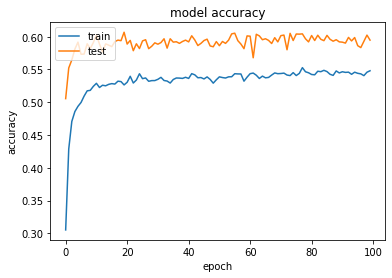

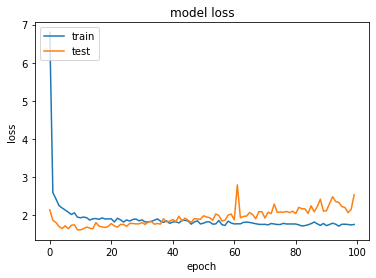

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

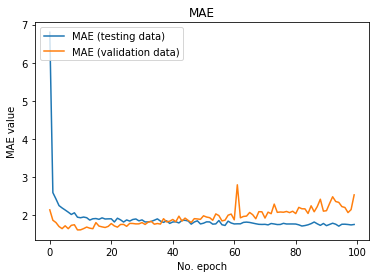

In [23]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

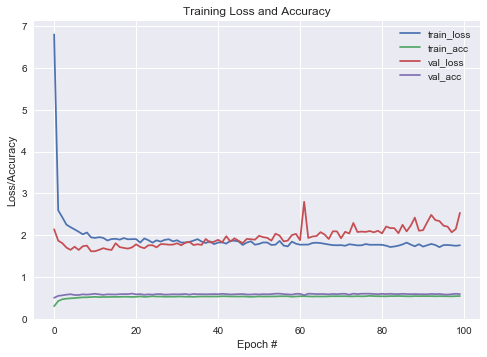

In [24]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochResNet101V2.png')
plt.close()